# No Preprocessing: Cats vs Dogs: Custom Model

Using the Cat vs Dog dataset, we will read the data files into memory as-is. The only processing that will be performed is reshaping the dataset into squares, since the neural network structure used requires the inputs to be of fixed dimensions. We will feed the dataset into a customly defined Convolutional Neural Network model, which will be trained for 25 epochs. This is intended to act as a baseline for this model/dataset, showing how the network performs without any regularization schemes. 

## Imports

Before we begin, we need to import the necessary python packages and appropriately configure the tensorflow gpu enviornment for use with the correct GPU on this system (RTX 2070 in GPU slot 0). 

* **`numpy`:** used for matrix operations, storing the pixel data of the images while working
* **`pandas`:** used for tabular organization of the results for storing in a formatted csv style for later evaluation in another notebook
* **`matplotlib.pyplot`:** used for data visualization for the model performance after training
* **`cv2`:** OpenCV for python, used for reading and manipulating the image files from the dataset before storing in working memory.
* **`os`:** used for streamlined access of the filesystem for determining the paths to each of the data files
* **`tensorflow.keras`:** used for model creation, compiling, and training. The GPU variant of tensorflow was used; this program has not been tested for systems without access to the GPU acclerations. 
* **`sklearn.utils.shuffle`:** used for an efficient shuffling of the X and y datasets together. 
* **`timeit.default_timer`:** used for timing the overhead and training runtime performance of the model when no preprocessing is performed

In [1]:
# === Imports === #
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import kerastuner        as kt
import cv2
import os
from tensorflow    import keras
from sklearn.utils import shuffle
from timeit        import default_timer


# === Extra Configurations for the GPU Environment === #
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# === Total Times Log === #
times = list( )

## Determine Train/Test Data Files

First, we need to determine the files which are to be used for training and validation. In order to do this, we will use our knowledge of the filesystem structure for the project, as well as the os listdir function to produce two lists: one of the filepaths used for the training data, and one of the filepaths used for the validation data. Finally, the first ten items of each list are printed to verify the success of the file list creation. 

In [2]:
# === Setup Variables === #
data_root_dir   = 'Dataset/Dog_vs_Cat/'
data_classes    = os.listdir( data_root_dir + 'training_set/' )
training_subdir = 'training_set/'
testing_subdir  = 'test_set/'
training_files  = [ ]
testing_files   = [ ]


# === For Each Class, Add Files to Appropriate List === #
for data_class in data_classes:
    for f in os.listdir( data_root_dir + training_subdir + data_class + '/' ):
        training_files.append( data_root_dir + training_subdir + data_class + '/' + f )
    for f in os.listdir( data_root_dir + testing_subdir + data_class + '/' ):
        testing_files.append( data_root_dir + testing_subdir + data_class + '/' + f )

    
# === Show First 10 of Each to Prove Success === #
print( 'Training Set:\n{}'.format( training_files[:10] ) )
print( '\nTesting Set: \n{}'.format( testing_files[:10] ) )

Training Set:
['Dataset/Dog_vs_Cat/training_set/cats/cat.1.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.10.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.100.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1000.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1001.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1002.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1003.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1004.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1005.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1006.jpg']

Testing Set: 
['Dataset/Dog_vs_Cat/test_set/cats/cat.4001.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4002.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4003.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4004.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4005.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4006.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4007.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4008.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4009.jpg', 'Dat

## Get Image Data & Label from File Names

Using our two file lists, we need to read the image data into working memory for the model to use in the training process. Since our model requires all training and validation data to be of the same shape, reshaping the image as its read will be the only transformation performed on the data. Analyzing the dataset showed that the average training image shape was `(360,400)`. In order to maintain the integrity of the experiment, all images were manually reshaped to be a square of this larger dimension `(400,400)`. We keep the read images as 8-bit integers without regularization, and we keep the RGB color scheme of the images. 

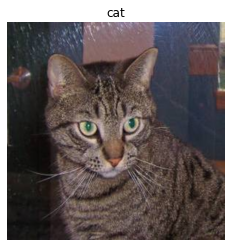

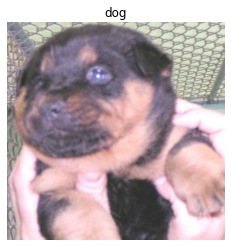

In [3]:
# ================================================================================
# FUNCTION: files_to_Xy( file_list , desired_shape )
# ================================================================================
# 
# Input: 
#   - file_list: list of filepaths to be read (as generated in the previous cell)
#   - desired_shape (optional): dimensions to transform the image data into
#        * default = (400,400,3): a 400x400 RGB image
#
# Output:
#   - Numpy array of shape (n,h,w,c) containing every image present in the list
#        * n = number of images listed to be read
#        * h = first dimension of desired_shape: height of image 
#        * w = second dimension of desired_shape: width of image
#        * c = third dimension of desired_shape: number of channels in the image (RGB=3)
#
# Task:
#   1. Iterate over the file list
#   2. Parse the y label for the image out of the file path
#   3. Use OpenCV (cv2) to read the image data and reshape appropriately
#   4. store the image data/label into numpy arrays of the desired shape
#   5. return the populated X and y after finished iterating
#
# ================================================================================
def files_to_Xy( file_list , desired_shape=(400,400,3) ):
    
    # === Setup Variables === #
    X = np.empty( (len( file_list ), desired_shape[0], desired_shape[1], desired_shape[2] ) , dtype=np.uint8 )
    y = np.empty( len( file_list ) , dtype=object )
    
    # === Iterate Files === #
    for i in range( len( file_list ) ):
        y[i] = file_list[i][ file_list[i].rfind('/')+1:file_list[i].index( '.' ) ]  # either "dog" or "cat"
        X[i] = cv2.cvtColor( 
                    cv2.resize( 
                        cv2.imread( file_list[i] , cv2.IMREAD_UNCHANGED ), 
                        ( desired_shape[0] , desired_shape[1] ) 
                    ), 
                    cv2.COLOR_BGR2RGB )  # read as rgb instead of bgr
        
    # === Return Results === #
    return X , y



# ================================================================================
# FUNCTION: show_image( X , y , idx )
# ================================================================================
#
# Input:
#   - X: numpy array containing the image data
#   - y: numpy array containing the corresponding class labels
#   - idx: index of the image to be shown
#
# Output:
#   - no return
#   - matplotlib imshow figure displayed
#
# Task:
#   1. using matplotlib.pyplot.imshow() to display the specified image
#
# Note:
#   - This function is not necessary for program completion, but it serves as a 
#     utility function to help demonstrate the success of the other necessary 
#     functions. 
#
# ================================================================================
def show_image( X , y , idx ):
    plt.figure( )
    plt.axis( 'off' )
    plt.imshow( X[idx] )
    plt.title( y[idx] )
    plt.show( )
        
        
        
# === Use Function to Get Train/Test Data === #
start             = default_timer( )
X_train , y_train = files_to_Xy( training_files )
X_test  , y_test  = files_to_Xy( testing_files  )
end               = default_timer( )
times.append( { 'Event': 'Load/Process Dataset' , 'Time (sec)': end - start } )



# === Show First and Last Images and Classes as Proof === #
show_image( X_train , y_train , 0 )
show_image( X_train , y_train , y_train.shape[0] - 1 )

## Shuffle the Training Data

Shuffling the training data is an important step to be performed before training any model. This helps to allow fairness in the training, and ensure the model is learning most effectively without encountering any biases due to ordering (for example, all cats are listed before all dogs currently, so the model may overfit to dogs before learning anything about cats).

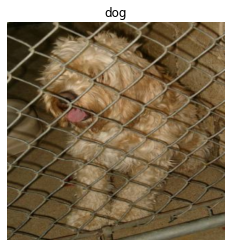

In [4]:
# === Shuffle X and y Together === #
X_train , y_train = shuffle( X_train , y_train )


# === Prove by Printing First Again to show it's Different === #
show_image( X_train , y_train , 0 )

## Convert Classes from Strings to Integers

Keras models don't handle categorical classes as well as numerical classes -- especially fora  binary classifier. Because of this, instead of having two class categories, we will translate the two possible classes to either a zero or a one to let the numerical output of the model specify the predicted class of the data. 

    Cat --> 0
    Dog --> 1

This translation is performed against both the training and validation labels. 

In [5]:
# === Key to Translate in Either Direction
label_keys = {
    'cat' : 0,
    'dog' : 1,
    0     : 'cat',
    1     : 'dog'
}

# === Update Training y === #
y_train[y_train=='cat'] = 0
y_train[y_train=='dog'] = 1
y_train = y_train.astype( X_train.dtype )

# === Update Testing y === #
y_test[y_test=='cat'] = 0
y_test[y_test=='dog'] = 1
y_test = y_test.astype( X_test.dtype )

# === Prove Success === #
y_train

array([1, 1, 0, ..., 1, 1, 0], dtype=uint8)

## Create Model with Tuning Options

We will be using a convolutional neural network, whose layers are specified below. The model contains three convolution layers, each with the same size kernel, but twice as many filters as the previous. After each convolution layer is a 2x2 pooling layer in order to keep the number of parameters from exploding to a number too large for the current GPU to handle (the RTX 2070 has 8GB of memory available). After the final convolution and pooling, we flatten the results, and use two fully connected layers for the classification -- the first having 64 nodes, and the second having a single node. All layers which utilize an activation function use the ReLU function, except for the output layer, which uses sigmoid. 

In terms of tuning, we will test ten different learning rates between `1e-5` and `1e-4` in order to determine which one best converges the model in terms of accuracy. 

In [6]:
def model_builder( hp ):
    model_layers = [
        keras.Input( shape=X_train[0].shape , name='Input_Layer'),

        keras.layers.Conv2D( 32, kernel_size=( 3 , 3 ), activation='relu', name='Convolution_1' ),
        keras.layers.MaxPooling2D( pool_size=( 2 , 2 ), name='Pooling_1' ),

        keras.layers.Conv2D( 64, kernel_size=( 3 , 3 ), activation='relu', name='Convolution_2' ),
        keras.layers.MaxPooling2D( pool_size=( 2 , 2 ), name='Pooling_2' ),

        keras.layers.Conv2D( 128, kernel_size=( 3 , 3 ), activation='relu', name='Convolution_3' ),
        keras.layers.MaxPooling2D( pool_size=( 2 , 2 ), name='Pooling_3' ),

        keras.layers.Flatten( ),

        keras.layers.Dense( 64 , activation='relu' , name='Dense_1' ),

        keras.layers.Dense( 1 , activation='sigmoid' , name='Output' )
    ]
    model            = keras.Sequential( layers=model_layers )
    hp_learning_rate = hp.Choice('learning_rate', values=list(np.linspace(0.000001, 0.00001, 10)))
    optimizer        = keras.optimizers.Adam( lr=hp_learning_rate )
    model.compile( optimizer=optimizer , loss="binary_crossentropy" , metrics=["accuracy"])
    return model

## Tune the Model

Using the keras-tuner package, we will tune the learning rate for the model in order to achieve the optimal validation accuracy via the hyperband tuning altorithm. This value may overfit, but it shows an example of how light tuning may result in better val accuracy in an automated tuning for this specific model architecture. 

In [7]:
start      = default_timer( )
tuner      = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=10, factor=3, hyperband_iterations=10, directory=os.path.normpath('C:/Users/dryyo/Documents/keras_tuner'), project_name='NoPreprocess' , overwrite=True)
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train, y_train, epochs=25, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_early])
best_hps   = tuner.get_best_hyperparameters(num_trials=1)[0]
end        = default_timer( )
times.append( { 'Event': 'Hyperparameter Tuning' , 'Time (sec)': end - start } )

print('The Optimal Leanring Rate is: {}'.format(best_hps.get('learning_rate')))

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


3232/8000 [===========>..................] - ETA: 18:14 - loss: 3.3154 - accuracy: 0.750 - ETA: 9:19 - loss: 5.7526 - accuracy: 0.656 - ETA: 6:21 - loss: 5.3014 - accuracy: 0.58 - ETA: 4:51 - loss: 5.6407 - accuracy: 0.51 - ETA: 3:58 - loss: 5.5765 - accuracy: 0.50 - ETA: 3:22 - loss: 6.5830 - accuracy: 0.48 - ETA: 2:36 - loss: 6.6139 - accuracy: 0.46 - ETA: 2:22 - loss: 6.4932 - accuracy: 0.47 - ETA: 2:10 - loss: 6.3163 - accuracy: 0.47 - ETA: 2:00 - loss: 5.9476 - accuracy: 0.48 - ETA: 1:52 - loss: 5.6815 - accuracy: 0.48 - ETA: 1:45 - loss: 5.4106 - accuracy: 0.50 - ETA: 1:34 - loss: 5.0601 - accuracy: 0.50 - ETA: 1:29 - loss: 4.8832 - accuracy: 0.50 - ETA: 1:25 - loss: 4.8429 - accuracy: 0.50 - ETA: 1:22 - loss: 4.7179 - accuracy: 0.50 - ETA: 1:19 - loss: 4.5868 - accuracy: 0.50 - ETA: 1:16 - loss: 4.6222 - accuracy: 0.48 - ETA: 1:13 - loss: 4.4972 - accuracy: 0.49 - ETA: 1:11 - loss: 4.4887 - accuracy: 0.49 - ETA: 1:09 - loss: 4.4401 - accuracy: 0.50 - ETA: 1:07 - loss: 4.3208 - a

8000/8000 [==============================] - ETA: 5s - loss: 1.9880 - accuracy: 0.56 - ETA: 5s - loss: 1.9874 - accuracy: 0.56 - ETA: 5s - loss: 1.9883 - accuracy: 0.56 - ETA: 5s - loss: 1.9881 - accuracy: 0.56 - ETA: 5s - loss: 1.9865 - accuracy: 0.56 - ETA: 5s - loss: 1.9848 - accuracy: 0.56 - ETA: 5s - loss: 1.9816 - accuracy: 0.56 - ETA: 5s - loss: 1.9783 - accuracy: 0.56 - ETA: 4s - loss: 1.9762 - accuracy: 0.56 - ETA: 4s - loss: 1.9753 - accuracy: 0.56 - ETA: 4s - loss: 1.9741 - accuracy: 0.56 - ETA: 4s - loss: 1.9727 - accuracy: 0.56 - ETA: 4s - loss: 1.9730 - accuracy: 0.56 - ETA: 4s - loss: 1.9711 - accuracy: 0.56 - ETA: 4s - loss: 1.9683 - accuracy: 0.56 - ETA: 4s - loss: 1.9663 - accuracy: 0.56 - ETA: 4s - loss: 1.9625 - accuracy: 0.56 - ETA: 4s - loss: 1.9600 - accuracy: 0.56 - ETA: 4s - loss: 1.9568 - accuracy: 0.56 - ETA: 4s - loss: 1.9518 - accuracy: 0.56 - ETA: 4s - loss: 1.9488 - accuracy: 0.56 - ETA: 4s - loss: 1.9463 - accuracy: 0.56 - ETA: 4s - loss: 1.9456 - accura

3200/8000 [===========>..................] - ETA: 26s - loss: 0.9038 - accuracy: 0.562 - ETA: 26s - loss: 0.7593 - accuracy: 0.656 - ETA: 26s - loss: 0.8695 - accuracy: 0.604 - ETA: 26s - loss: 0.8869 - accuracy: 0.625 - ETA: 26s - loss: 0.9239 - accuracy: 0.625 - ETA: 26s - loss: 0.8596 - accuracy: 0.666 - ETA: 26s - loss: 0.8369 - accuracy: 0.669 - ETA: 26s - loss: 0.8717 - accuracy: 0.656 - ETA: 25s - loss: 0.8488 - accuracy: 0.656 - ETA: 25s - loss: 0.9336 - accuracy: 0.636 - ETA: 25s - loss: 0.9399 - accuracy: 0.645 - ETA: 25s - loss: 0.9745 - accuracy: 0.644 - ETA: 25s - loss: 0.9436 - accuracy: 0.651 - ETA: 25s - loss: 0.9931 - accuracy: 0.637 - ETA: 25s - loss: 0.9998 - accuracy: 0.636 - ETA: 25s - loss: 0.9855 - accuracy: 0.628 - ETA: 25s - loss: 0.9499 - accuracy: 0.638 - ETA: 25s - loss: 0.9492 - accuracy: 0.644 - ETA: 25s - loss: 0.9518 - accuracy: 0.643 - ETA: 25s - loss: 0.9473 - accuracy: 0.645 - ETA: 25s - loss: 0.9281 - accuracy: 0.650 - ETA: 25s - loss: 0.9359 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.8993 - accuracy: 0.60 - ETA: 5s - loss: 0.8996 - accuracy: 0.60 - ETA: 5s - loss: 0.8989 - accuracy: 0.60 - ETA: 5s - loss: 0.8980 - accuracy: 0.61 - ETA: 5s - loss: 0.8969 - accuracy: 0.61 - ETA: 4s - loss: 0.8966 - accuracy: 0.61 - ETA: 4s - loss: 0.8956 - accuracy: 0.61 - ETA: 4s - loss: 0.8963 - accuracy: 0.61 - ETA: 4s - loss: 0.8963 - accuracy: 0.61 - ETA: 4s - loss: 0.8953 - accuracy: 0.61 - ETA: 4s - loss: 0.8961 - accuracy: 0.60 - ETA: 4s - loss: 0.8951 - accuracy: 0.61 - ETA: 4s - loss: 0.8944 - accuracy: 0.61 - ETA: 4s - loss: 0.8940 - accuracy: 0.61 - ETA: 4s - loss: 0.8930 - accuracy: 0.61 - ETA: 4s - loss: 0.8924 - accuracy: 0.61 - ETA: 4s - loss: 0.8914 - accuracy: 0.61 - ETA: 4s - loss: 0.8905 - accuracy: 0.61 - ETA: 4s - loss: 0.8898 - accuracy: 0.61 - ETA: 4s - loss: 0.8896 - accuracy: 0.61 - ETA: 4s - loss: 0.8888 - accuracy: 0.61 - ETA: 4s - loss: 0.8886 - accuracy: 0.61 - ETA: 4s - loss: 0.8882 - accura

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


3040/8000 [==========>...................] - ETA: 3:23 - loss: 1.7086 - accuracy: 0.43 - ETA: 1:55 - loss: 7.2914 - accuracy: 0.46 - ETA: 1:25 - loss: 15.1301 - accuracy: 0.500 - ETA: 1:10 - loss: 20.6237 - accuracy: 0.500 - ETA: 1:01 - loss: 18.6206 - accuracy: 0.512 - ETA: 55s - loss: 16.6359 - accuracy: 0.520 - ETA: 51s - loss: 16.4044 - accuracy: 0.53 - ETA: 48s - loss: 17.0152 - accuracy: 0.50 - ETA: 45s - loss: 15.8165 - accuracy: 0.51 - ETA: 43s - loss: 15.4336 - accuracy: 0.51 - ETA: 41s - loss: 15.1617 - accuracy: 0.51 - ETA: 40s - loss: 14.2515 - accuracy: 0.53 - ETA: 39s - loss: 13.5809 - accuracy: 0.53 - ETA: 38s - loss: 12.8579 - accuracy: 0.55 - ETA: 37s - loss: 13.1616 - accuracy: 0.54 - ETA: 36s - loss: 12.7297 - accuracy: 0.53 - ETA: 35s - loss: 12.3747 - accuracy: 0.52 - ETA: 35s - loss: 11.9815 - accuracy: 0.52 - ETA: 34s - loss: 11.4613 - accuracy: 0.52 - ETA: 34s - loss: 11.0101 - accuracy: 0.53 - ETA: 33s - loss: 10.7719 - accuracy: 0.53 - ETA: 33s - loss: 10.3688

8000/8000 [==============================] - ETA: 6s - loss: 2.8232 - accuracy: 0.55 - ETA: 6s - loss: 2.8300 - accuracy: 0.55 - ETA: 6s - loss: 2.8304 - accuracy: 0.55 - ETA: 6s - loss: 2.8288 - accuracy: 0.55 - ETA: 5s - loss: 2.8242 - accuracy: 0.55 - ETA: 5s - loss: 2.8215 - accuracy: 0.55 - ETA: 5s - loss: 2.8212 - accuracy: 0.55 - ETA: 5s - loss: 2.8209 - accuracy: 0.55 - ETA: 5s - loss: 2.8152 - accuracy: 0.55 - ETA: 5s - loss: 2.8097 - accuracy: 0.55 - ETA: 5s - loss: 2.8070 - accuracy: 0.55 - ETA: 5s - loss: 2.8032 - accuracy: 0.55 - ETA: 5s - loss: 2.7992 - accuracy: 0.55 - ETA: 5s - loss: 2.7965 - accuracy: 0.55 - ETA: 5s - loss: 2.7922 - accuracy: 0.55 - ETA: 5s - loss: 2.7894 - accuracy: 0.55 - ETA: 5s - loss: 2.7854 - accuracy: 0.55 - ETA: 5s - loss: 2.7810 - accuracy: 0.55 - ETA: 5s - loss: 2.7784 - accuracy: 0.56 - ETA: 5s - loss: 2.7744 - accuracy: 0.56 - ETA: 5s - loss: 2.7708 - accuracy: 0.56 - ETA: 5s - loss: 2.7658 - accuracy: 0.56 - ETA: 4s - loss: 2.7611 - accura

3232/8000 [===========>..................] - ETA: 24s - loss: 1.5885 - accuracy: 0.500 - ETA: 25s - loss: 1.0800 - accuracy: 0.625 - ETA: 25s - loss: 0.9368 - accuracy: 0.666 - ETA: 26s - loss: 1.0753 - accuracy: 0.625 - ETA: 26s - loss: 1.1737 - accuracy: 0.587 - ETA: 26s - loss: 1.0541 - accuracy: 0.625 - ETA: 26s - loss: 1.0939 - accuracy: 0.616 - ETA: 25s - loss: 1.2121 - accuracy: 0.583 - ETA: 26s - loss: 1.1500 - accuracy: 0.593 - ETA: 26s - loss: 1.1368 - accuracy: 0.596 - ETA: 26s - loss: 1.2293 - accuracy: 0.588 - ETA: 26s - loss: 1.2613 - accuracy: 0.581 - ETA: 26s - loss: 1.2787 - accuracy: 0.584 - ETA: 26s - loss: 1.3253 - accuracy: 0.566 - ETA: 26s - loss: 1.3674 - accuracy: 0.554 - ETA: 26s - loss: 1.3557 - accuracy: 0.544 - ETA: 26s - loss: 1.3278 - accuracy: 0.545 - ETA: 25s - loss: 1.3407 - accuracy: 0.549 - ETA: 25s - loss: 1.3296 - accuracy: 0.553 - ETA: 25s - loss: 1.2976 - accuracy: 0.559 - ETA: 25s - loss: 1.2962 - accuracy: 0.556 - ETA: 25s - loss: 1.2445 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.8431 - accuracy: 0.64 - ETA: 5s - loss: 0.8425 - accuracy: 0.64 - ETA: 5s - loss: 0.8437 - accuracy: 0.64 - ETA: 5s - loss: 0.8437 - accuracy: 0.64 - ETA: 5s - loss: 0.8436 - accuracy: 0.64 - ETA: 5s - loss: 0.8426 - accuracy: 0.64 - ETA: 5s - loss: 0.8418 - accuracy: 0.64 - ETA: 5s - loss: 0.8408 - accuracy: 0.64 - ETA: 5s - loss: 0.8399 - accuracy: 0.64 - ETA: 5s - loss: 0.8393 - accuracy: 0.64 - ETA: 5s - loss: 0.8387 - accuracy: 0.64 - ETA: 4s - loss: 0.8408 - accuracy: 0.64 - ETA: 4s - loss: 0.8423 - accuracy: 0.64 - ETA: 4s - loss: 0.8416 - accuracy: 0.64 - ETA: 4s - loss: 0.8424 - accuracy: 0.64 - ETA: 4s - loss: 0.8432 - accuracy: 0.64 - ETA: 4s - loss: 0.8428 - accuracy: 0.64 - ETA: 4s - loss: 0.8420 - accuracy: 0.64 - ETA: 4s - loss: 0.8420 - accuracy: 0.64 - ETA: 4s - loss: 0.8432 - accuracy: 0.64 - ETA: 4s - loss: 0.8452 - accuracy: 0.64 - ETA: 4s - loss: 0.8458 - accuracy: 0.64 - ETA: 4s - loss: 0.8470 - accura

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


3024/8000 [==========>...................] - ETA: 3:14 - loss: 6.3515 - accuracy: 0.43 - ETA: 1:52 - loss: 5.8201 - accuracy: 0.37 - ETA: 1:24 - loss: 5.0805 - accuracy: 0.41 - ETA: 1:09 - loss: 4.7045 - accuracy: 0.45 - ETA: 1:00 - loss: 4.8357 - accuracy: 0.42 - ETA: 55s - loss: 4.4266 - accuracy: 0.4583 - ETA: 51s - loss: 4.1695 - accuracy: 0.464 - ETA: 47s - loss: 3.9379 - accuracy: 0.460 - ETA: 45s - loss: 3.7216 - accuracy: 0.486 - ETA: 43s - loss: 3.6192 - accuracy: 0.500 - ETA: 41s - loss: 3.3696 - accuracy: 0.528 - ETA: 40s - loss: 3.3023 - accuracy: 0.526 - ETA: 37s - loss: 3.2885 - accuracy: 0.522 - ETA: 37s - loss: 3.1900 - accuracy: 0.529 - ETA: 36s - loss: 3.1101 - accuracy: 0.535 - ETA: 36s - loss: 3.1294 - accuracy: 0.533 - ETA: 35s - loss: 3.2061 - accuracy: 0.531 - ETA: 34s - loss: 3.2821 - accuracy: 0.523 - ETA: 34s - loss: 3.2866 - accuracy: 0.521 - ETA: 33s - loss: 3.2345 - accuracy: 0.520 - ETA: 33s - loss: 3.2233 - accuracy: 0.519 - ETA: 33s - loss: 3.1533 - accu

8000/8000 [==============================] - ETA: 6s - loss: 1.3959 - accuracy: 0.55 - ETA: 5s - loss: 1.3927 - accuracy: 0.55 - ETA: 5s - loss: 1.3915 - accuracy: 0.55 - ETA: 5s - loss: 1.3911 - accuracy: 0.55 - ETA: 5s - loss: 1.3886 - accuracy: 0.55 - ETA: 5s - loss: 1.3865 - accuracy: 0.55 - ETA: 5s - loss: 1.3876 - accuracy: 0.55 - ETA: 5s - loss: 1.3863 - accuracy: 0.55 - ETA: 5s - loss: 1.3853 - accuracy: 0.55 - ETA: 5s - loss: 1.3847 - accuracy: 0.55 - ETA: 5s - loss: 1.3834 - accuracy: 0.55 - ETA: 5s - loss: 1.3825 - accuracy: 0.55 - ETA: 5s - loss: 1.3816 - accuracy: 0.55 - ETA: 5s - loss: 1.3801 - accuracy: 0.55 - ETA: 5s - loss: 1.3787 - accuracy: 0.55 - ETA: 5s - loss: 1.3771 - accuracy: 0.55 - ETA: 5s - loss: 1.3760 - accuracy: 0.54 - ETA: 5s - loss: 1.3757 - accuracy: 0.54 - ETA: 4s - loss: 1.3744 - accuracy: 0.54 - ETA: 4s - loss: 1.3747 - accuracy: 0.54 - ETA: 4s - loss: 1.3733 - accuracy: 0.54 - ETA: 4s - loss: 1.3719 - accuracy: 0.54 - ETA: 4s - loss: 1.3705 - accura

3120/8000 [==========>...................] - ETA: 22s - loss: 0.3489 - accuracy: 0.875 - ETA: 24s - loss: 0.5417 - accuracy: 0.718 - ETA: 25s - loss: 0.5897 - accuracy: 0.687 - ETA: 25s - loss: 0.6186 - accuracy: 0.703 - ETA: 25s - loss: 0.6527 - accuracy: 0.675 - ETA: 25s - loss: 0.7748 - accuracy: 0.635 - ETA: 26s - loss: 0.7831 - accuracy: 0.616 - ETA: 26s - loss: 0.7580 - accuracy: 0.625 - ETA: 26s - loss: 0.7782 - accuracy: 0.597 - ETA: 26s - loss: 0.7571 - accuracy: 0.606 - ETA: 26s - loss: 0.7459 - accuracy: 0.608 - ETA: 26s - loss: 0.7803 - accuracy: 0.599 - ETA: 26s - loss: 0.7846 - accuracy: 0.591 - ETA: 25s - loss: 0.7710 - accuracy: 0.595 - ETA: 25s - loss: 0.7572 - accuracy: 0.601 - ETA: 25s - loss: 0.7539 - accuracy: 0.606 - ETA: 26s - loss: 0.7474 - accuracy: 0.607 - ETA: 26s - loss: 0.7458 - accuracy: 0.605 - ETA: 26s - loss: 0.7457 - accuracy: 0.603 - ETA: 25s - loss: 0.7592 - accuracy: 0.601 - ETA: 25s - loss: 0.7520 - accuracy: 0.605 - ETA: 25s - loss: 0.7532 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.8149 - accuracy: 0.58 - ETA: 6s - loss: 0.8149 - accuracy: 0.58 - ETA: 6s - loss: 0.8150 - accuracy: 0.58 - ETA: 5s - loss: 0.8149 - accuracy: 0.58 - ETA: 5s - loss: 0.8144 - accuracy: 0.58 - ETA: 5s - loss: 0.8140 - accuracy: 0.58 - ETA: 5s - loss: 0.8146 - accuracy: 0.58 - ETA: 5s - loss: 0.8152 - accuracy: 0.58 - ETA: 5s - loss: 0.8153 - accuracy: 0.58 - ETA: 5s - loss: 0.8151 - accuracy: 0.58 - ETA: 5s - loss: 0.8153 - accuracy: 0.58 - ETA: 5s - loss: 0.8152 - accuracy: 0.58 - ETA: 5s - loss: 0.8146 - accuracy: 0.58 - ETA: 5s - loss: 0.8140 - accuracy: 0.58 - ETA: 5s - loss: 0.8138 - accuracy: 0.58 - ETA: 5s - loss: 0.8140 - accuracy: 0.58 - ETA: 5s - loss: 0.8139 - accuracy: 0.58 - ETA: 5s - loss: 0.8136 - accuracy: 0.58 - ETA: 5s - loss: 0.8132 - accuracy: 0.58 - ETA: 5s - loss: 0.8126 - accuracy: 0.58 - ETA: 5s - loss: 0.8124 - accuracy: 0.58 - ETA: 4s - loss: 0.8131 - accuracy: 0.58 - ETA: 4s - loss: 0.8133 - accura

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


3024/8000 [==========>...................] - ETA: 3:14 - loss: 2.5971 - accuracy: 0.50 - ETA: 1:53 - loss: 13.3197 - accuracy: 0.437 - ETA: 1:24 - loss: 11.1935 - accuracy: 0.541 - ETA: 1:10 - loss: 9.5596 - accuracy: 0.515 - ETA: 1:01 - loss: 8.6087 - accuracy: 0.51 - ETA: 55s - loss: 9.2858 - accuracy: 0.5000 - ETA: 51s - loss: 9.0644 - accuracy: 0.500 - ETA: 48s - loss: 8.5304 - accuracy: 0.500 - ETA: 45s - loss: 7.8187 - accuracy: 0.500 - ETA: 43s - loss: 7.3383 - accuracy: 0.506 - ETA: 42s - loss: 6.9233 - accuracy: 0.511 - ETA: 40s - loss: 6.6850 - accuracy: 0.510 - ETA: 39s - loss: 6.3306 - accuracy: 0.524 - ETA: 38s - loss: 5.8926 - accuracy: 0.553 - ETA: 37s - loss: 5.6258 - accuracy: 0.558 - ETA: 36s - loss: 5.5486 - accuracy: 0.550 - ETA: 36s - loss: 5.3338 - accuracy: 0.551 - ETA: 35s - loss: 5.1536 - accuracy: 0.548 - ETA: 35s - loss: 5.0361 - accuracy: 0.539 - ETA: 34s - loss: 4.8758 - accuracy: 0.537 - ETA: 34s - loss: 4.7022 - accuracy: 0.538 - ETA: 33s - loss: 4.6081 -

8000/8000 [==============================] - ETA: 6s - loss: 1.4237 - accuracy: 0.55 - ETA: 6s - loss: 1.4246 - accuracy: 0.55 - ETA: 6s - loss: 1.4225 - accuracy: 0.55 - ETA: 6s - loss: 1.4204 - accuracy: 0.56 - ETA: 6s - loss: 1.4185 - accuracy: 0.56 - ETA: 6s - loss: 1.4161 - accuracy: 0.56 - ETA: 6s - loss: 1.4167 - accuracy: 0.56 - ETA: 6s - loss: 1.4149 - accuracy: 0.56 - ETA: 6s - loss: 1.4142 - accuracy: 0.56 - ETA: 6s - loss: 1.4128 - accuracy: 0.56 - ETA: 6s - loss: 1.4121 - accuracy: 0.55 - ETA: 6s - loss: 1.4120 - accuracy: 0.56 - ETA: 5s - loss: 1.4096 - accuracy: 0.56 - ETA: 5s - loss: 1.4077 - accuracy: 0.56 - ETA: 5s - loss: 1.4054 - accuracy: 0.56 - ETA: 5s - loss: 1.4050 - accuracy: 0.56 - ETA: 5s - loss: 1.4034 - accuracy: 0.56 - ETA: 5s - loss: 1.4019 - accuracy: 0.56 - ETA: 5s - loss: 1.4002 - accuracy: 0.56 - ETA: 5s - loss: 1.3990 - accuracy: 0.56 - ETA: 5s - loss: 1.3980 - accuracy: 0.56 - ETA: 5s - loss: 1.3969 - accuracy: 0.56 - ETA: 5s - loss: 1.3951 - accura

3056/8000 [==========>...................] - ETA: 26s - loss: 0.5660 - accuracy: 0.750 - ETA: 26s - loss: 0.5711 - accuracy: 0.750 - ETA: 26s - loss: 0.5857 - accuracy: 0.729 - ETA: 26s - loss: 0.5644 - accuracy: 0.734 - ETA: 26s - loss: 0.7323 - accuracy: 0.687 - ETA: 27s - loss: 0.7478 - accuracy: 0.666 - ETA: 27s - loss: 0.7738 - accuracy: 0.642 - ETA: 26s - loss: 0.7659 - accuracy: 0.632 - ETA: 26s - loss: 0.7177 - accuracy: 0.652 - ETA: 26s - loss: 0.7193 - accuracy: 0.643 - ETA: 27s - loss: 0.7285 - accuracy: 0.642 - ETA: 27s - loss: 0.7270 - accuracy: 0.635 - ETA: 26s - loss: 0.7080 - accuracy: 0.653 - ETA: 26s - loss: 0.6941 - accuracy: 0.665 - ETA: 26s - loss: 0.6859 - accuracy: 0.675 - ETA: 26s - loss: 0.6963 - accuracy: 0.671 - ETA: 26s - loss: 0.7511 - accuracy: 0.656 - ETA: 26s - loss: 0.7826 - accuracy: 0.644 - ETA: 26s - loss: 0.7835 - accuracy: 0.650 - ETA: 26s - loss: 0.7795 - accuracy: 0.654 - ETA: 26s - loss: 0.8068 - accuracy: 0.650 - ETA: 26s - loss: 0.8301 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.7335 - accuracy: 0.65 - ETA: 6s - loss: 0.7340 - accuracy: 0.65 - ETA: 6s - loss: 0.7333 - accuracy: 0.65 - ETA: 6s - loss: 0.7340 - accuracy: 0.65 - ETA: 6s - loss: 0.7340 - accuracy: 0.65 - ETA: 6s - loss: 0.7345 - accuracy: 0.65 - ETA: 5s - loss: 0.7351 - accuracy: 0.65 - ETA: 5s - loss: 0.7349 - accuracy: 0.65 - ETA: 5s - loss: 0.7348 - accuracy: 0.65 - ETA: 5s - loss: 0.7360 - accuracy: 0.65 - ETA: 5s - loss: 0.7368 - accuracy: 0.65 - ETA: 5s - loss: 0.7372 - accuracy: 0.65 - ETA: 5s - loss: 0.7368 - accuracy: 0.65 - ETA: 5s - loss: 0.7362 - accuracy: 0.65 - ETA: 5s - loss: 0.7357 - accuracy: 0.65 - ETA: 5s - loss: 0.7364 - accuracy: 0.65 - ETA: 5s - loss: 0.7368 - accuracy: 0.65 - ETA: 5s - loss: 0.7363 - accuracy: 0.65 - ETA: 5s - loss: 0.7351 - accuracy: 0.65 - ETA: 5s - loss: 0.7354 - accuracy: 0.65 - ETA: 5s - loss: 0.7356 - accuracy: 0.65 - ETA: 5s - loss: 0.7368 - accuracy: 0.65 - ETA: 5s - loss: 0.7369 - accura

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


3008/8000 [==========>...................] - ETA: 3:17 - loss: 5.2173 - accuracy: 0.50 - ETA: 1:53 - loss: 8.5323 - accuracy: 0.53 - ETA: 1:24 - loss: 10.9825 - accuracy: 0.500 - ETA: 1:09 - loss: 9.8533 - accuracy: 0.531 - ETA: 1:01 - loss: 8.2623 - accuracy: 0.50 - ETA: 55s - loss: 7.9882 - accuracy: 0.4688 - ETA: 50s - loss: 7.7086 - accuracy: 0.455 - ETA: 48s - loss: 7.0671 - accuracy: 0.476 - ETA: 45s - loss: 6.6741 - accuracy: 0.458 - ETA: 43s - loss: 6.3022 - accuracy: 0.456 - ETA: 42s - loss: 5.9238 - accuracy: 0.465 - ETA: 40s - loss: 5.5786 - accuracy: 0.463 - ETA: 39s - loss: 5.2588 - accuracy: 0.466 - ETA: 38s - loss: 4.9877 - accuracy: 0.477 - ETA: 37s - loss: 4.7919 - accuracy: 0.479 - ETA: 37s - loss: 4.5927 - accuracy: 0.484 - ETA: 36s - loss: 4.4270 - accuracy: 0.477 - ETA: 35s - loss: 4.2600 - accuracy: 0.482 - ETA: 35s - loss: 4.2286 - accuracy: 0.480 - ETA: 34s - loss: 4.1043 - accuracy: 0.484 - ETA: 34s - loss: 3.9586 - accuracy: 0.494 - ETA: 33s - loss: 3.8695 - a

8000/8000 [==============================] - ETA: 6s - loss: 1.0879 - accuracy: 0.56 - ETA: 6s - loss: 1.0862 - accuracy: 0.56 - ETA: 6s - loss: 1.0854 - accuracy: 0.56 - ETA: 6s - loss: 1.0855 - accuracy: 0.56 - ETA: 6s - loss: 1.0852 - accuracy: 0.56 - ETA: 6s - loss: 1.0840 - accuracy: 0.56 - ETA: 6s - loss: 1.0838 - accuracy: 0.56 - ETA: 6s - loss: 1.0830 - accuracy: 0.56 - ETA: 6s - loss: 1.0816 - accuracy: 0.56 - ETA: 6s - loss: 1.0806 - accuracy: 0.56 - ETA: 6s - loss: 1.0796 - accuracy: 0.56 - ETA: 6s - loss: 1.0790 - accuracy: 0.56 - ETA: 6s - loss: 1.0780 - accuracy: 0.56 - ETA: 6s - loss: 1.0771 - accuracy: 0.56 - ETA: 6s - loss: 1.0759 - accuracy: 0.56 - ETA: 5s - loss: 1.0754 - accuracy: 0.56 - ETA: 5s - loss: 1.0745 - accuracy: 0.56 - ETA: 5s - loss: 1.0732 - accuracy: 0.56 - ETA: 5s - loss: 1.0733 - accuracy: 0.56 - ETA: 5s - loss: 1.0720 - accuracy: 0.56 - ETA: 5s - loss: 1.0711 - accuracy: 0.56 - ETA: 5s - loss: 1.0700 - accuracy: 0.56 - ETA: 5s - loss: 1.0691 - accura

3056/8000 [==========>...................] - ETA: 26s - loss: 1.7454 - accuracy: 0.375 - ETA: 26s - loss: 1.3924 - accuracy: 0.437 - ETA: 26s - loss: 1.2018 - accuracy: 0.500 - ETA: 26s - loss: 1.0934 - accuracy: 0.515 - ETA: 27s - loss: 1.0422 - accuracy: 0.537 - ETA: 27s - loss: 1.0642 - accuracy: 0.541 - ETA: 27s - loss: 1.0579 - accuracy: 0.535 - ETA: 26s - loss: 1.0058 - accuracy: 0.539 - ETA: 26s - loss: 0.9457 - accuracy: 0.562 - ETA: 26s - loss: 0.9586 - accuracy: 0.556 - ETA: 26s - loss: 0.9275 - accuracy: 0.562 - ETA: 26s - loss: 0.8961 - accuracy: 0.578 - ETA: 26s - loss: 0.8604 - accuracy: 0.591 - ETA: 26s - loss: 0.8554 - accuracy: 0.593 - ETA: 26s - loss: 0.8445 - accuracy: 0.595 - ETA: 26s - loss: 0.8599 - accuracy: 0.582 - ETA: 26s - loss: 0.8429 - accuracy: 0.591 - ETA: 26s - loss: 0.8258 - accuracy: 0.600 - ETA: 26s - loss: 0.8231 - accuracy: 0.602 - ETA: 26s - loss: 0.8219 - accuracy: 0.603 - ETA: 26s - loss: 0.8062 - accuracy: 0.604 - ETA: 26s - loss: 0.7995 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.6445 - accuracy: 0.66 - ETA: 6s - loss: 0.6438 - accuracy: 0.66 - ETA: 6s - loss: 0.6435 - accuracy: 0.66 - ETA: 6s - loss: 0.6443 - accuracy: 0.66 - ETA: 6s - loss: 0.6443 - accuracy: 0.66 - ETA: 6s - loss: 0.6441 - accuracy: 0.66 - ETA: 6s - loss: 0.6446 - accuracy: 0.66 - ETA: 6s - loss: 0.6437 - accuracy: 0.66 - ETA: 6s - loss: 0.6431 - accuracy: 0.66 - ETA: 6s - loss: 0.6435 - accuracy: 0.66 - ETA: 6s - loss: 0.6429 - accuracy: 0.66 - ETA: 5s - loss: 0.6424 - accuracy: 0.67 - ETA: 5s - loss: 0.6421 - accuracy: 0.67 - ETA: 5s - loss: 0.6418 - accuracy: 0.67 - ETA: 5s - loss: 0.6414 - accuracy: 0.67 - ETA: 5s - loss: 0.6417 - accuracy: 0.67 - ETA: 5s - loss: 0.6414 - accuracy: 0.67 - ETA: 5s - loss: 0.6410 - accuracy: 0.67 - ETA: 5s - loss: 0.6406 - accuracy: 0.67 - ETA: 5s - loss: 0.6402 - accuracy: 0.67 - ETA: 5s - loss: 0.6401 - accuracy: 0.67 - ETA: 5s - loss: 0.6402 - accuracy: 0.67 - ETA: 5s - loss: 0.6401 - accura

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


3024/8000 [==========>...................] - ETA: 3:14 - loss: 2.9781 - accuracy: 0.56 - ETA: 1:54 - loss: 3.1377 - accuracy: 0.62 - ETA: 1:25 - loss: 3.0043 - accuracy: 0.54 - ETA: 1:10 - loss: 2.9270 - accuracy: 0.56 - ETA: 1:01 - loss: 2.8376 - accuracy: 0.55 - ETA: 55s - loss: 3.0185 - accuracy: 0.5417 - ETA: 51s - loss: 3.3769 - accuracy: 0.535 - ETA: 48s - loss: 3.6180 - accuracy: 0.546 - ETA: 45s - loss: 4.1919 - accuracy: 0.520 - ETA: 44s - loss: 4.2577 - accuracy: 0.525 - ETA: 42s - loss: 4.5275 - accuracy: 0.517 - ETA: 41s - loss: 4.3089 - accuracy: 0.531 - ETA: 39s - loss: 4.2104 - accuracy: 0.538 - ETA: 38s - loss: 4.0919 - accuracy: 0.544 - ETA: 36s - loss: 4.0719 - accuracy: 0.535 - ETA: 36s - loss: 3.9729 - accuracy: 0.536 - ETA: 35s - loss: 3.8266 - accuracy: 0.545 - ETA: 35s - loss: 3.7426 - accuracy: 0.549 - ETA: 34s - loss: 3.8189 - accuracy: 0.553 - ETA: 34s - loss: 3.8120 - accuracy: 0.550 - ETA: 33s - loss: 3.7481 - accuracy: 0.548 - ETA: 33s - loss: 3.7720 - accu

8000/8000 [==============================] - ETA: 6s - loss: 1.5215 - accuracy: 0.54 - ETA: 6s - loss: 1.5211 - accuracy: 0.54 - ETA: 6s - loss: 1.5191 - accuracy: 0.54 - ETA: 6s - loss: 1.5171 - accuracy: 0.54 - ETA: 6s - loss: 1.5175 - accuracy: 0.54 - ETA: 6s - loss: 1.5157 - accuracy: 0.54 - ETA: 6s - loss: 1.5149 - accuracy: 0.54 - ETA: 6s - loss: 1.5130 - accuracy: 0.54 - ETA: 6s - loss: 1.5107 - accuracy: 0.54 - ETA: 6s - loss: 1.5098 - accuracy: 0.54 - ETA: 5s - loss: 1.5095 - accuracy: 0.54 - ETA: 5s - loss: 1.5081 - accuracy: 0.54 - ETA: 5s - loss: 1.5060 - accuracy: 0.54 - ETA: 5s - loss: 1.5047 - accuracy: 0.54 - ETA: 5s - loss: 1.5032 - accuracy: 0.54 - ETA: 5s - loss: 1.5013 - accuracy: 0.54 - ETA: 5s - loss: 1.4996 - accuracy: 0.54 - ETA: 5s - loss: 1.4985 - accuracy: 0.54 - ETA: 5s - loss: 1.4970 - accuracy: 0.54 - ETA: 5s - loss: 1.4955 - accuracy: 0.54 - ETA: 5s - loss: 1.4934 - accuracy: 0.54 - ETA: 5s - loss: 1.4926 - accuracy: 0.54 - ETA: 5s - loss: 1.4913 - accura

3072/8000 [==========>...................] - ETA: 25s - loss: 0.9925 - accuracy: 0.562 - ETA: 26s - loss: 1.0559 - accuracy: 0.500 - ETA: 26s - loss: 1.0766 - accuracy: 0.500 - ETA: 26s - loss: 0.9510 - accuracy: 0.562 - ETA: 27s - loss: 1.0046 - accuracy: 0.525 - ETA: 27s - loss: 1.1038 - accuracy: 0.510 - ETA: 27s - loss: 1.1010 - accuracy: 0.517 - ETA: 26s - loss: 1.1105 - accuracy: 0.515 - ETA: 27s - loss: 1.0776 - accuracy: 0.527 - ETA: 26s - loss: 1.0340 - accuracy: 0.551 - ETA: 26s - loss: 1.0489 - accuracy: 0.541 - ETA: 26s - loss: 1.0440 - accuracy: 0.552 - ETA: 26s - loss: 1.0306 - accuracy: 0.553 - ETA: 26s - loss: 1.0376 - accuracy: 0.550 - ETA: 26s - loss: 1.0299 - accuracy: 0.550 - ETA: 26s - loss: 1.0352 - accuracy: 0.540 - ETA: 26s - loss: 1.0452 - accuracy: 0.545 - ETA: 26s - loss: 1.0752 - accuracy: 0.536 - ETA: 26s - loss: 1.0623 - accuracy: 0.537 - ETA: 26s - loss: 1.0496 - accuracy: 0.535 - ETA: 26s - loss: 1.0345 - accuracy: 0.545 - ETA: 26s - loss: 1.0295 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.7799 - accuracy: 0.61 - ETA: 6s - loss: 0.7791 - accuracy: 0.61 - ETA: 6s - loss: 0.7795 - accuracy: 0.61 - ETA: 6s - loss: 0.7794 - accuracy: 0.61 - ETA: 6s - loss: 0.7786 - accuracy: 0.61 - ETA: 6s - loss: 0.7788 - accuracy: 0.61 - ETA: 6s - loss: 0.7788 - accuracy: 0.61 - ETA: 6s - loss: 0.7776 - accuracy: 0.61 - ETA: 6s - loss: 0.7770 - accuracy: 0.61 - ETA: 5s - loss: 0.7764 - accuracy: 0.61 - ETA: 5s - loss: 0.7761 - accuracy: 0.61 - ETA: 5s - loss: 0.7756 - accuracy: 0.61 - ETA: 5s - loss: 0.7752 - accuracy: 0.61 - ETA: 5s - loss: 0.7751 - accuracy: 0.61 - ETA: 5s - loss: 0.7748 - accuracy: 0.61 - ETA: 5s - loss: 0.7741 - accuracy: 0.61 - ETA: 5s - loss: 0.7743 - accuracy: 0.61 - ETA: 5s - loss: 0.7735 - accuracy: 0.61 - ETA: 5s - loss: 0.7735 - accuracy: 0.61 - ETA: 5s - loss: 0.7730 - accuracy: 0.61 - ETA: 5s - loss: 0.7729 - accuracy: 0.61 - ETA: 5s - loss: 0.7723 - accuracy: 0.61 - ETA: 5s - loss: 0.7717 - accura

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


3008/8000 [==========>...................] - ETA: 3:35 - loss: 9.1747 - accuracy: 0.50 - ETA: 2:00 - loss: 17.8378 - accuracy: 0.406 - ETA: 1:29 - loss: 15.0869 - accuracy: 0.458 - ETA: 1:14 - loss: 12.0203 - accuracy: 0.468 - ETA: 1:05 - loss: 11.1638 - accuracy: 0.462 - ETA: 58s - loss: 10.6769 - accuracy: 0.458 - ETA: 53s - loss: 9.4485 - accuracy: 0.4643 - ETA: 50s - loss: 8.7470 - accuracy: 0.453 - ETA: 47s - loss: 8.1228 - accuracy: 0.465 - ETA: 45s - loss: 7.7082 - accuracy: 0.462 - ETA: 41s - loss: 6.7819 - accuracy: 0.484 - ETA: 40s - loss: 6.4001 - accuracy: 0.500 - ETA: 39s - loss: 6.1249 - accuracy: 0.504 - ETA: 37s - loss: 5.5250 - accuracy: 0.523 - ETA: 37s - loss: 5.2761 - accuracy: 0.525 - ETA: 36s - loss: 5.0415 - accuracy: 0.538 - ETA: 35s - loss: 4.8975 - accuracy: 0.546 - ETA: 35s - loss: 4.7103 - accuracy: 0.553 - ETA: 34s - loss: 4.5694 - accuracy: 0.553 - ETA: 34s - loss: 4.5195 - accuracy: 0.545 - ETA: 34s - loss: 4.3921 - accuracy: 0.548 - ETA: 33s - loss: 4.36

8000/8000 [==============================] - ETA: 6s - loss: 1.2333 - accuracy: 0.52 - ETA: 6s - loss: 1.2304 - accuracy: 0.52 - ETA: 6s - loss: 1.2291 - accuracy: 0.52 - ETA: 6s - loss: 1.2277 - accuracy: 0.52 - ETA: 6s - loss: 1.2263 - accuracy: 0.52 - ETA: 6s - loss: 1.2250 - accuracy: 0.52 - ETA: 6s - loss: 1.2236 - accuracy: 0.52 - ETA: 6s - loss: 1.2222 - accuracy: 0.52 - ETA: 6s - loss: 1.2209 - accuracy: 0.52 - ETA: 6s - loss: 1.2195 - accuracy: 0.52 - ETA: 5s - loss: 1.2182 - accuracy: 0.52 - ETA: 5s - loss: 1.2168 - accuracy: 0.52 - ETA: 5s - loss: 1.2154 - accuracy: 0.52 - ETA: 5s - loss: 1.2142 - accuracy: 0.52 - ETA: 5s - loss: 1.2128 - accuracy: 0.52 - ETA: 5s - loss: 1.2115 - accuracy: 0.52 - ETA: 5s - loss: 1.2101 - accuracy: 0.52 - ETA: 5s - loss: 1.2088 - accuracy: 0.52 - ETA: 5s - loss: 1.2075 - accuracy: 0.52 - ETA: 5s - loss: 1.2062 - accuracy: 0.52 - ETA: 5s - loss: 1.2049 - accuracy: 0.52 - ETA: 5s - loss: 1.2036 - accuracy: 0.52 - ETA: 5s - loss: 1.2024 - accura

3040/8000 [==========>...................] - ETA: 27s - loss: 0.6831 - accuracy: 0.562 - ETA: 27s - loss: 0.6878 - accuracy: 0.562 - ETA: 27s - loss: 0.6880 - accuracy: 0.541 - ETA: 26s - loss: 0.6930 - accuracy: 0.500 - ETA: 26s - loss: 0.6901 - accuracy: 0.550 - ETA: 26s - loss: 0.6883 - accuracy: 0.572 - ETA: 26s - loss: 0.6892 - accuracy: 0.562 - ETA: 27s - loss: 0.6891 - accuracy: 0.554 - ETA: 27s - loss: 0.6878 - accuracy: 0.548 - ETA: 26s - loss: 0.6874 - accuracy: 0.550 - ETA: 26s - loss: 0.6885 - accuracy: 0.522 - ETA: 26s - loss: 0.6901 - accuracy: 0.500 - ETA: 26s - loss: 0.6906 - accuracy: 0.485 - ETA: 26s - loss: 0.6899 - accuracy: 0.491 - ETA: 26s - loss: 0.6896 - accuracy: 0.495 - ETA: 26s - loss: 0.6898 - accuracy: 0.484 - ETA: 26s - loss: 0.6894 - accuracy: 0.492 - ETA: 26s - loss: 0.6893 - accuracy: 0.489 - ETA: 26s - loss: 0.6894 - accuracy: 0.486 - ETA: 26s - loss: 0.6886 - accuracy: 0.494 - ETA: 26s - loss: 0.6888 - accuracy: 0.497 - ETA: 26s - loss: 0.6883 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.6860 - accuracy: 0.53 - ETA: 6s - loss: 0.6860 - accuracy: 0.53 - ETA: 6s - loss: 0.6860 - accuracy: 0.53 - ETA: 6s - loss: 0.6859 - accuracy: 0.53 - ETA: 5s - loss: 0.6860 - accuracy: 0.53 - ETA: 5s - loss: 0.6858 - accuracy: 0.53 - ETA: 5s - loss: 0.6857 - accuracy: 0.53 - ETA: 5s - loss: 0.6858 - accuracy: 0.53 - ETA: 5s - loss: 0.6857 - accuracy: 0.53 - ETA: 5s - loss: 0.6858 - accuracy: 0.53 - ETA: 5s - loss: 0.6858 - accuracy: 0.53 - ETA: 5s - loss: 0.6857 - accuracy: 0.53 - ETA: 5s - loss: 0.6858 - accuracy: 0.53 - ETA: 5s - loss: 0.6859 - accuracy: 0.53 - ETA: 5s - loss: 0.6859 - accuracy: 0.53 - ETA: 5s - loss: 0.6859 - accuracy: 0.53 - ETA: 5s - loss: 0.6857 - accuracy: 0.53 - ETA: 5s - loss: 0.6858 - accuracy: 0.53 - ETA: 5s - loss: 0.6858 - accuracy: 0.53 - ETA: 5s - loss: 0.6859 - accuracy: 0.53 - ETA: 5s - loss: 0.6859 - accuracy: 0.53 - ETA: 5s - loss: 0.6860 - accuracy: 0.53 - ETA: 4s - loss: 0.6861 - accura

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


3040/8000 [==========>...................] - ETA: 3:23 - loss: 4.1420 - accuracy: 0.37 - ETA: 1:55 - loss: 23.5709 - accuracy: 0.406 - ETA: 1:25 - loss: 18.5104 - accuracy: 0.479 - ETA: 1:11 - loss: 19.8793 - accuracy: 0.484 - ETA: 1:02 - loss: 21.6004 - accuracy: 0.437 - ETA: 56s - loss: 18.9298 - accuracy: 0.447 - ETA: 52s - loss: 17.5196 - accuracy: 0.46 - ETA: 48s - loss: 17.5977 - accuracy: 0.46 - ETA: 46s - loss: 17.4387 - accuracy: 0.45 - ETA: 44s - loss: 16.0230 - accuracy: 0.48 - ETA: 42s - loss: 15.1263 - accuracy: 0.48 - ETA: 41s - loss: 14.7697 - accuracy: 0.47 - ETA: 40s - loss: 14.0344 - accuracy: 0.47 - ETA: 39s - loss: 13.2180 - accuracy: 0.47 - ETA: 38s - loss: 12.5144 - accuracy: 0.49 - ETA: 37s - loss: 12.3210 - accuracy: 0.48 - ETA: 36s - loss: 12.0851 - accuracy: 0.48 - ETA: 36s - loss: 11.4909 - accuracy: 0.50 - ETA: 34s - loss: 10.7711 - accuracy: 0.49 - ETA: 34s - loss: 10.8280 - accuracy: 0.48 - ETA: 34s - loss: 10.4531 - accuracy: 0.49 - ETA: 33s - loss: 10.16

8000/8000 [==============================] - ETA: 6s - loss: 2.5885 - accuracy: 0.57 - ETA: 6s - loss: 2.5848 - accuracy: 0.57 - ETA: 6s - loss: 2.5826 - accuracy: 0.57 - ETA: 6s - loss: 2.5822 - accuracy: 0.57 - ETA: 6s - loss: 2.5791 - accuracy: 0.57 - ETA: 6s - loss: 2.5763 - accuracy: 0.57 - ETA: 6s - loss: 2.5751 - accuracy: 0.57 - ETA: 6s - loss: 2.5745 - accuracy: 0.57 - ETA: 6s - loss: 2.5701 - accuracy: 0.57 - ETA: 6s - loss: 2.5653 - accuracy: 0.57 - ETA: 6s - loss: 2.5643 - accuracy: 0.57 - ETA: 5s - loss: 2.5623 - accuracy: 0.57 - ETA: 5s - loss: 2.5588 - accuracy: 0.57 - ETA: 5s - loss: 2.5543 - accuracy: 0.57 - ETA: 5s - loss: 2.5508 - accuracy: 0.57 - ETA: 5s - loss: 2.5484 - accuracy: 0.57 - ETA: 5s - loss: 2.5440 - accuracy: 0.57 - ETA: 5s - loss: 2.5428 - accuracy: 0.57 - ETA: 5s - loss: 2.5385 - accuracy: 0.57 - ETA: 5s - loss: 2.5333 - accuracy: 0.57 - ETA: 5s - loss: 2.5289 - accuracy: 0.57 - ETA: 5s - loss: 2.5242 - accuracy: 0.57 - ETA: 5s - loss: 2.5197 - accura

3088/8000 [==========>...................] - ETA: 27s - loss: 0.3724 - accuracy: 0.750 - ETA: 24s - loss: 0.5032 - accuracy: 0.708 - ETA: 26s - loss: 0.7756 - accuracy: 0.656 - ETA: 26s - loss: 0.7201 - accuracy: 0.662 - ETA: 26s - loss: 0.8053 - accuracy: 0.645 - ETA: 26s - loss: 0.8341 - accuracy: 0.625 - ETA: 26s - loss: 0.8295 - accuracy: 0.617 - ETA: 26s - loss: 0.8011 - accuracy: 0.638 - ETA: 26s - loss: 0.8055 - accuracy: 0.637 - ETA: 26s - loss: 0.8335 - accuracy: 0.630 - ETA: 26s - loss: 0.8323 - accuracy: 0.635 - ETA: 26s - loss: 0.8093 - accuracy: 0.644 - ETA: 26s - loss: 0.8364 - accuracy: 0.638 - ETA: 26s - loss: 0.8320 - accuracy: 0.645 - ETA: 26s - loss: 0.8464 - accuracy: 0.647 - ETA: 26s - loss: 0.8414 - accuracy: 0.649 - ETA: 26s - loss: 0.8981 - accuracy: 0.648 - ETA: 26s - loss: 0.9802 - accuracy: 0.634 - ETA: 26s - loss: 0.9409 - accuracy: 0.651 - ETA: 26s - loss: 0.9671 - accuracy: 0.639 - ETA: 26s - loss: 0.9856 - accuracy: 0.633 - ETA: 26s - loss: 0.9850 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.9613 - accuracy: 0.66 - ETA: 6s - loss: 0.9609 - accuracy: 0.66 - ETA: 6s - loss: 0.9616 - accuracy: 0.66 - ETA: 6s - loss: 0.9649 - accuracy: 0.66 - ETA: 6s - loss: 0.9662 - accuracy: 0.66 - ETA: 5s - loss: 0.9655 - accuracy: 0.66 - ETA: 5s - loss: 0.9670 - accuracy: 0.66 - ETA: 5s - loss: 0.9679 - accuracy: 0.66 - ETA: 5s - loss: 0.9665 - accuracy: 0.66 - ETA: 5s - loss: 0.9662 - accuracy: 0.66 - ETA: 5s - loss: 0.9662 - accuracy: 0.66 - ETA: 5s - loss: 0.9661 - accuracy: 0.66 - ETA: 5s - loss: 0.9652 - accuracy: 0.66 - ETA: 5s - loss: 0.9666 - accuracy: 0.66 - ETA: 5s - loss: 0.9655 - accuracy: 0.66 - ETA: 5s - loss: 0.9645 - accuracy: 0.66 - ETA: 5s - loss: 0.9651 - accuracy: 0.66 - ETA: 5s - loss: 0.9638 - accuracy: 0.66 - ETA: 5s - loss: 0.9646 - accuracy: 0.66 - ETA: 5s - loss: 0.9647 - accuracy: 0.66 - ETA: 5s - loss: 0.9633 - accuracy: 0.66 - ETA: 5s - loss: 0.9646 - accuracy: 0.66 - ETA: 5s - loss: 0.9653 - accura

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


3088/8000 [==========>...................] - ETA: 3:15 - loss: 2.0101 - accuracy: 0.62 - ETA: 1:51 - loss: 7.4441 - accuracy: 0.65 - ETA: 1:23 - loss: 11.6281 - accuracy: 0.604 - ETA: 1:10 - loss: 10.3108 - accuracy: 0.562 - ETA: 1:01 - loss: 10.0817 - accuracy: 0.537 - ETA: 55s - loss: 9.7954 - accuracy: 0.5417  - ETA: 51s - loss: 9.2614 - accuracy: 0.562 - ETA: 48s - loss: 8.8032 - accuracy: 0.562 - ETA: 45s - loss: 8.1590 - accuracy: 0.541 - ETA: 43s - loss: 7.8421 - accuracy: 0.525 - ETA: 41s - loss: 7.5833 - accuracy: 0.534 - ETA: 40s - loss: 7.6103 - accuracy: 0.520 - ETA: 39s - loss: 7.2013 - accuracy: 0.538 - ETA: 38s - loss: 6.8296 - accuracy: 0.540 - ETA: 37s - loss: 6.4803 - accuracy: 0.541 - ETA: 37s - loss: 6.2728 - accuracy: 0.539 - ETA: 36s - loss: 6.1367 - accuracy: 0.547 - ETA: 35s - loss: 5.9843 - accuracy: 0.548 - ETA: 34s - loss: 5.5251 - accuracy: 0.546 - ETA: 34s - loss: 5.3214 - accuracy: 0.550 - ETA: 33s - loss: 5.1785 - accuracy: 0.542 - ETA: 33s - loss: 4.9960

8000/8000 [==============================] - ETA: 6s - loss: 1.3410 - accuracy: 0.57 - ETA: 6s - loss: 1.3386 - accuracy: 0.57 - ETA: 6s - loss: 1.3365 - accuracy: 0.57 - ETA: 6s - loss: 1.3350 - accuracy: 0.57 - ETA: 5s - loss: 1.3321 - accuracy: 0.57 - ETA: 5s - loss: 1.3303 - accuracy: 0.57 - ETA: 5s - loss: 1.3290 - accuracy: 0.57 - ETA: 5s - loss: 1.3270 - accuracy: 0.57 - ETA: 5s - loss: 1.3264 - accuracy: 0.57 - ETA: 5s - loss: 1.3250 - accuracy: 0.57 - ETA: 5s - loss: 1.3248 - accuracy: 0.57 - ETA: 5s - loss: 1.3235 - accuracy: 0.57 - ETA: 5s - loss: 1.3218 - accuracy: 0.57 - ETA: 5s - loss: 1.3200 - accuracy: 0.57 - ETA: 5s - loss: 1.3203 - accuracy: 0.57 - ETA: 5s - loss: 1.3207 - accuracy: 0.57 - ETA: 5s - loss: 1.3200 - accuracy: 0.57 - ETA: 5s - loss: 1.3208 - accuracy: 0.57 - ETA: 5s - loss: 1.3238 - accuracy: 0.57 - ETA: 5s - loss: 1.3245 - accuracy: 0.57 - ETA: 4s - loss: 1.3249 - accuracy: 0.57 - ETA: 4s - loss: 1.3229 - accuracy: 0.57 - ETA: 4s - loss: 1.3214 - accura

3104/8000 [==========>...................] - ETA: 24s - loss: 0.6384 - accuracy: 0.687 - ETA: 25s - loss: 0.5463 - accuracy: 0.750 - ETA: 26s - loss: 0.5533 - accuracy: 0.770 - ETA: 25s - loss: 0.7074 - accuracy: 0.675 - ETA: 26s - loss: 0.6691 - accuracy: 0.687 - ETA: 26s - loss: 0.6632 - accuracy: 0.660 - ETA: 26s - loss: 0.6370 - accuracy: 0.664 - ETA: 26s - loss: 0.6330 - accuracy: 0.680 - ETA: 26s - loss: 0.6498 - accuracy: 0.675 - ETA: 26s - loss: 0.6615 - accuracy: 0.670 - ETA: 26s - loss: 0.6804 - accuracy: 0.671 - ETA: 26s - loss: 0.6835 - accuracy: 0.668 - ETA: 26s - loss: 0.7143 - accuracy: 0.651 - ETA: 26s - loss: 0.7133 - accuracy: 0.654 - ETA: 26s - loss: 0.7014 - accuracy: 0.660 - ETA: 26s - loss: 0.7050 - accuracy: 0.658 - ETA: 26s - loss: 0.6859 - accuracy: 0.670 - ETA: 26s - loss: 0.7136 - accuracy: 0.661 - ETA: 26s - loss: 0.6967 - accuracy: 0.665 - ETA: 26s - loss: 0.6862 - accuracy: 0.669 - ETA: 26s - loss: 0.6896 - accuracy: 0.670 - ETA: 26s - loss: 0.7001 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.6800 - accuracy: 0.67 - ETA: 6s - loss: 0.6801 - accuracy: 0.67 - ETA: 6s - loss: 0.6797 - accuracy: 0.67 - ETA: 6s - loss: 0.6801 - accuracy: 0.67 - ETA: 5s - loss: 0.6794 - accuracy: 0.67 - ETA: 5s - loss: 0.6787 - accuracy: 0.67 - ETA: 5s - loss: 0.6790 - accuracy: 0.67 - ETA: 5s - loss: 0.6788 - accuracy: 0.67 - ETA: 5s - loss: 0.6790 - accuracy: 0.67 - ETA: 5s - loss: 0.6786 - accuracy: 0.67 - ETA: 5s - loss: 0.6782 - accuracy: 0.67 - ETA: 5s - loss: 0.6771 - accuracy: 0.67 - ETA: 5s - loss: 0.6763 - accuracy: 0.67 - ETA: 5s - loss: 0.6762 - accuracy: 0.67 - ETA: 5s - loss: 0.6759 - accuracy: 0.67 - ETA: 5s - loss: 0.6763 - accuracy: 0.67 - ETA: 5s - loss: 0.6763 - accuracy: 0.67 - ETA: 5s - loss: 0.6756 - accuracy: 0.67 - ETA: 5s - loss: 0.6749 - accuracy: 0.67 - ETA: 5s - loss: 0.6756 - accuracy: 0.67 - ETA: 5s - loss: 0.6768 - accuracy: 0.67 - ETA: 5s - loss: 0.6767 - accuracy: 0.67 - ETA: 4s - loss: 0.6766 - accura

INFO:tensorflow:Oracle triggered exit
The Optimal Leanring Rate is: 8e-06


## Compile Best Model

Using the highest-performing tuned hyperparameters, build the model using those parameters and show a summary of that built model. 

In [8]:
hypermodel = tuner.hypermodel.build( best_hps )
hypermodel.summary( )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Convolution_1 (Conv2D)       (None, 398, 398, 32)      896       
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 199, 199, 32)      0         
_________________________________________________________________
Convolution_2 (Conv2D)       (None, 197, 197, 64)      18496     
_________________________________________________________________
Pooling_2 (MaxPooling2D)     (None, 98, 98, 64)        0         
_________________________________________________________________
Convolution_3 (Conv2D)       (None, 96, 96, 128)       73856     
_________________________________________________________________
Pooling_3 (MaxPooling2D)     (None, 48, 48, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 294912)            0

## Train the Model

Using the optimally found hyperparameters and a batch size of 16, train the model for 25 epochs. 

In [9]:
start        = default_timer( )
history      = hypermodel.fit( X_train, 
                               y_train, 
                               epochs=25, 
                               batch_size=16, 
                               validation_data=( X_test , y_test ) )
end          = default_timer( )
history_dict = history.history
times.append( { 'Event': 'Training' , 'Time (sec)': end - start } )

Train on 8000 samples, validate on 2000 samples
Epoch 1/25


3088/8000 [==========>...................] - ETA: 3:19 - loss: 2.4433 - accuracy: 0.75 - ETA: 1:53 - loss: 19.2306 - accuracy: 0.562 - ETA: 1:24 - loss: 14.8229 - accuracy: 0.562 - ETA: 1:10 - loss: 15.6316 - accuracy: 0.546 - ETA: 1:01 - loss: 16.6934 - accuracy: 0.525 - ETA: 55s - loss: 15.5169 - accuracy: 0.531 - ETA: 50s - loss: 13.7066 - accuracy: 0.50 - ETA: 48s - loss: 13.2814 - accuracy: 0.49 - ETA: 45s - loss: 12.0329 - accuracy: 0.52 - ETA: 43s - loss: 11.1561 - accuracy: 0.51 - ETA: 42s - loss: 10.3193 - accuracy: 0.50 - ETA: 41s - loss: 9.6418 - accuracy: 0.5104 - ETA: 38s - loss: 8.4872 - accuracy: 0.522 - ETA: 37s - loss: 8.0649 - accuracy: 0.525 - ETA: 37s - loss: 7.7192 - accuracy: 0.519 - ETA: 36s - loss: 7.3671 - accuracy: 0.522 - ETA: 35s - loss: 6.9879 - accuracy: 0.531 - ETA: 35s - loss: 6.7056 - accuracy: 0.532 - ETA: 34s - loss: 6.4686 - accuracy: 0.534 - ETA: 34s - loss: 6.2088 - accuracy: 0.538 - ETA: 33s - loss: 5.9897 - accuracy: 0.534 - ETA: 33s - loss: 5.78

8000/8000 [==============================] - ETA: 6s - loss: 1.4021 - accuracy: 0.56 - ETA: 6s - loss: 1.4016 - accuracy: 0.56 - ETA: 6s - loss: 1.4007 - accuracy: 0.56 - ETA: 6s - loss: 1.3999 - accuracy: 0.56 - ETA: 6s - loss: 1.4016 - accuracy: 0.56 - ETA: 6s - loss: 1.3996 - accuracy: 0.56 - ETA: 6s - loss: 1.3977 - accuracy: 0.56 - ETA: 6s - loss: 1.3960 - accuracy: 0.56 - ETA: 6s - loss: 1.3950 - accuracy: 0.56 - ETA: 6s - loss: 1.3946 - accuracy: 0.56 - ETA: 5s - loss: 1.3932 - accuracy: 0.56 - ETA: 5s - loss: 1.3930 - accuracy: 0.56 - ETA: 5s - loss: 1.3926 - accuracy: 0.56 - ETA: 5s - loss: 1.3909 - accuracy: 0.56 - ETA: 5s - loss: 1.3895 - accuracy: 0.56 - ETA: 5s - loss: 1.3892 - accuracy: 0.56 - ETA: 5s - loss: 1.3891 - accuracy: 0.56 - ETA: 5s - loss: 1.3875 - accuracy: 0.56 - ETA: 5s - loss: 1.3868 - accuracy: 0.56 - ETA: 5s - loss: 1.3855 - accuracy: 0.56 - ETA: 5s - loss: 1.3841 - accuracy: 0.56 - ETA: 5s - loss: 1.3824 - accuracy: 0.56 - ETA: 5s - loss: 1.3805 - accura

3040/8000 [==========>...................] - ETA: 30s - loss: 0.5900 - accuracy: 0.812 - ETA: 29s - loss: 0.7196 - accuracy: 0.687 - ETA: 28s - loss: 0.7523 - accuracy: 0.604 - ETA: 27s - loss: 0.7466 - accuracy: 0.625 - ETA: 27s - loss: 0.7168 - accuracy: 0.612 - ETA: 27s - loss: 0.7052 - accuracy: 0.635 - ETA: 27s - loss: 0.7050 - accuracy: 0.633 - ETA: 27s - loss: 0.6952 - accuracy: 0.640 - ETA: 27s - loss: 0.6686 - accuracy: 0.652 - ETA: 27s - loss: 0.6712 - accuracy: 0.656 - ETA: 27s - loss: 0.6957 - accuracy: 0.647 - ETA: 27s - loss: 0.6850 - accuracy: 0.645 - ETA: 27s - loss: 0.6736 - accuracy: 0.653 - ETA: 27s - loss: 0.6574 - accuracy: 0.660 - ETA: 27s - loss: 0.6601 - accuracy: 0.658 - ETA: 26s - loss: 0.6554 - accuracy: 0.656 - ETA: 26s - loss: 0.6689 - accuracy: 0.654 - ETA: 26s - loss: 0.7040 - accuracy: 0.642 - ETA: 26s - loss: 0.6991 - accuracy: 0.644 - ETA: 26s - loss: 0.6942 - accuracy: 0.646 - ETA: 26s - loss: 0.7121 - accuracy: 0.642 - ETA: 26s - loss: 0.7242 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.6757 - accuracy: 0.67 - ETA: 6s - loss: 0.6760 - accuracy: 0.67 - ETA: 6s - loss: 0.6755 - accuracy: 0.67 - ETA: 6s - loss: 0.6749 - accuracy: 0.67 - ETA: 6s - loss: 0.6756 - accuracy: 0.67 - ETA: 6s - loss: 0.6763 - accuracy: 0.67 - ETA: 6s - loss: 0.6763 - accuracy: 0.67 - ETA: 6s - loss: 0.6760 - accuracy: 0.67 - ETA: 6s - loss: 0.6759 - accuracy: 0.67 - ETA: 6s - loss: 0.6764 - accuracy: 0.67 - ETA: 5s - loss: 0.6767 - accuracy: 0.67 - ETA: 5s - loss: 0.6763 - accuracy: 0.67 - ETA: 5s - loss: 0.6761 - accuracy: 0.67 - ETA: 5s - loss: 0.6791 - accuracy: 0.67 - ETA: 5s - loss: 0.6810 - accuracy: 0.67 - ETA: 5s - loss: 0.6810 - accuracy: 0.67 - ETA: 5s - loss: 0.6812 - accuracy: 0.67 - ETA: 5s - loss: 0.6810 - accuracy: 0.67 - ETA: 5s - loss: 0.6820 - accuracy: 0.67 - ETA: 5s - loss: 0.6822 - accuracy: 0.67 - ETA: 5s - loss: 0.6826 - accuracy: 0.67 - ETA: 5s - loss: 0.6820 - accuracy: 0.67 - ETA: 5s - loss: 0.6821 - accura

3088/8000 [==========>...................] - ETA: 27s - loss: 0.4844 - accuracy: 0.750 - ETA: 26s - loss: 0.4585 - accuracy: 0.718 - ETA: 26s - loss: 0.4872 - accuracy: 0.729 - ETA: 26s - loss: 0.4597 - accuracy: 0.750 - ETA: 26s - loss: 0.5199 - accuracy: 0.725 - ETA: 27s - loss: 0.5585 - accuracy: 0.718 - ETA: 27s - loss: 0.6076 - accuracy: 0.696 - ETA: 27s - loss: 0.5617 - accuracy: 0.726 - ETA: 26s - loss: 0.5628 - accuracy: 0.715 - ETA: 27s - loss: 0.5613 - accuracy: 0.725 - ETA: 27s - loss: 0.5602 - accuracy: 0.727 - ETA: 27s - loss: 0.5566 - accuracy: 0.729 - ETA: 27s - loss: 0.5827 - accuracy: 0.706 - ETA: 26s - loss: 0.5977 - accuracy: 0.705 - ETA: 26s - loss: 0.5864 - accuracy: 0.712 - ETA: 26s - loss: 0.5746 - accuracy: 0.718 - ETA: 26s - loss: 0.5886 - accuracy: 0.711 - ETA: 26s - loss: 0.5879 - accuracy: 0.710 - ETA: 26s - loss: 0.5832 - accuracy: 0.718 - ETA: 26s - loss: 0.5834 - accuracy: 0.720 - ETA: 26s - loss: 0.5800 - accuracy: 0.721 - ETA: 26s - loss: 0.5891 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.5681 - accuracy: 0.72 - ETA: 6s - loss: 0.5674 - accuracy: 0.72 - ETA: 6s - loss: 0.5679 - accuracy: 0.72 - ETA: 6s - loss: 0.5684 - accuracy: 0.72 - ETA: 6s - loss: 0.5685 - accuracy: 0.72 - ETA: 6s - loss: 0.5683 - accuracy: 0.72 - ETA: 6s - loss: 0.5679 - accuracy: 0.72 - ETA: 6s - loss: 0.5680 - accuracy: 0.72 - ETA: 5s - loss: 0.5686 - accuracy: 0.72 - ETA: 5s - loss: 0.5687 - accuracy: 0.72 - ETA: 5s - loss: 0.5689 - accuracy: 0.72 - ETA: 5s - loss: 0.5684 - accuracy: 0.72 - ETA: 5s - loss: 0.5682 - accuracy: 0.72 - ETA: 5s - loss: 0.5682 - accuracy: 0.72 - ETA: 5s - loss: 0.5677 - accuracy: 0.72 - ETA: 5s - loss: 0.5672 - accuracy: 0.72 - ETA: 5s - loss: 0.5674 - accuracy: 0.72 - ETA: 5s - loss: 0.5672 - accuracy: 0.72 - ETA: 5s - loss: 0.5670 - accuracy: 0.72 - ETA: 5s - loss: 0.5672 - accuracy: 0.72 - ETA: 5s - loss: 0.5673 - accuracy: 0.72 - ETA: 5s - loss: 0.5670 - accuracy: 0.72 - ETA: 5s - loss: 0.5669 - accura

3056/8000 [==========>...................] - ETA: 26s - loss: 0.6197 - accuracy: 0.750 - ETA: 26s - loss: 0.4993 - accuracy: 0.781 - ETA: 26s - loss: 0.5713 - accuracy: 0.708 - ETA: 27s - loss: 0.5597 - accuracy: 0.718 - ETA: 27s - loss: 0.5651 - accuracy: 0.737 - ETA: 27s - loss: 0.5409 - accuracy: 0.750 - ETA: 27s - loss: 0.5849 - accuracy: 0.741 - ETA: 27s - loss: 0.5707 - accuracy: 0.757 - ETA: 26s - loss: 0.5511 - accuracy: 0.770 - ETA: 26s - loss: 0.5390 - accuracy: 0.768 - ETA: 27s - loss: 0.5144 - accuracy: 0.789 - ETA: 27s - loss: 0.4963 - accuracy: 0.802 - ETA: 27s - loss: 0.4896 - accuracy: 0.802 - ETA: 26s - loss: 0.4775 - accuracy: 0.808 - ETA: 26s - loss: 0.4872 - accuracy: 0.800 - ETA: 26s - loss: 0.5087 - accuracy: 0.789 - ETA: 26s - loss: 0.5134 - accuracy: 0.775 - ETA: 26s - loss: 0.5061 - accuracy: 0.781 - ETA: 26s - loss: 0.5118 - accuracy: 0.776 - ETA: 26s - loss: 0.5365 - accuracy: 0.765 - ETA: 26s - loss: 0.5320 - accuracy: 0.764 - ETA: 26s - loss: 0.5235 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.4901 - accuracy: 0.76 - ETA: 6s - loss: 0.4898 - accuracy: 0.76 - ETA: 6s - loss: 0.4897 - accuracy: 0.76 - ETA: 6s - loss: 0.4892 - accuracy: 0.76 - ETA: 6s - loss: 0.4888 - accuracy: 0.76 - ETA: 6s - loss: 0.4884 - accuracy: 0.76 - ETA: 6s - loss: 0.4882 - accuracy: 0.76 - ETA: 6s - loss: 0.4879 - accuracy: 0.76 - ETA: 6s - loss: 0.4872 - accuracy: 0.76 - ETA: 6s - loss: 0.4868 - accuracy: 0.76 - ETA: 6s - loss: 0.4867 - accuracy: 0.76 - ETA: 6s - loss: 0.4861 - accuracy: 0.76 - ETA: 5s - loss: 0.4860 - accuracy: 0.76 - ETA: 5s - loss: 0.4877 - accuracy: 0.76 - ETA: 5s - loss: 0.4877 - accuracy: 0.76 - ETA: 5s - loss: 0.4871 - accuracy: 0.76 - ETA: 5s - loss: 0.4872 - accuracy: 0.76 - ETA: 5s - loss: 0.4867 - accuracy: 0.76 - ETA: 5s - loss: 0.4871 - accuracy: 0.76 - ETA: 5s - loss: 0.4868 - accuracy: 0.76 - ETA: 5s - loss: 0.4865 - accuracy: 0.76 - ETA: 5s - loss: 0.4861 - accuracy: 0.76 - ETA: 5s - loss: 0.4859 - accura

3056/8000 [==========>...................] - ETA: 29s - loss: 0.3634 - accuracy: 0.812 - ETA: 27s - loss: 0.3574 - accuracy: 0.843 - ETA: 27s - loss: 0.3465 - accuracy: 0.833 - ETA: 28s - loss: 0.3420 - accuracy: 0.828 - ETA: 28s - loss: 0.4067 - accuracy: 0.812 - ETA: 27s - loss: 0.4128 - accuracy: 0.802 - ETA: 27s - loss: 0.4326 - accuracy: 0.794 - ETA: 27s - loss: 0.4213 - accuracy: 0.796 - ETA: 27s - loss: 0.4057 - accuracy: 0.798 - ETA: 27s - loss: 0.4363 - accuracy: 0.775 - ETA: 27s - loss: 0.4577 - accuracy: 0.767 - ETA: 27s - loss: 0.4319 - accuracy: 0.786 - ETA: 27s - loss: 0.4292 - accuracy: 0.793 - ETA: 27s - loss: 0.4210 - accuracy: 0.794 - ETA: 27s - loss: 0.4440 - accuracy: 0.783 - ETA: 27s - loss: 0.4342 - accuracy: 0.785 - ETA: 27s - loss: 0.4239 - accuracy: 0.794 - ETA: 26s - loss: 0.4214 - accuracy: 0.798 - ETA: 26s - loss: 0.4181 - accuracy: 0.799 - ETA: 26s - loss: 0.4285 - accuracy: 0.788 - ETA: 26s - loss: 0.4240 - accuracy: 0.792 - ETA: 26s - loss: 0.4163 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.4018 - accuracy: 0.81 - ETA: 6s - loss: 0.4019 - accuracy: 0.81 - ETA: 6s - loss: 0.4015 - accuracy: 0.81 - ETA: 6s - loss: 0.4014 - accuracy: 0.81 - ETA: 6s - loss: 0.4010 - accuracy: 0.81 - ETA: 6s - loss: 0.4006 - accuracy: 0.81 - ETA: 6s - loss: 0.4006 - accuracy: 0.81 - ETA: 6s - loss: 0.4005 - accuracy: 0.81 - ETA: 6s - loss: 0.4001 - accuracy: 0.81 - ETA: 5s - loss: 0.3998 - accuracy: 0.81 - ETA: 5s - loss: 0.4001 - accuracy: 0.81 - ETA: 5s - loss: 0.4001 - accuracy: 0.81 - ETA: 5s - loss: 0.4000 - accuracy: 0.81 - ETA: 5s - loss: 0.4002 - accuracy: 0.81 - ETA: 5s - loss: 0.4002 - accuracy: 0.81 - ETA: 5s - loss: 0.3997 - accuracy: 0.81 - ETA: 5s - loss: 0.3998 - accuracy: 0.81 - ETA: 5s - loss: 0.3997 - accuracy: 0.81 - ETA: 5s - loss: 0.3999 - accuracy: 0.81 - ETA: 5s - loss: 0.3996 - accuracy: 0.81 - ETA: 5s - loss: 0.3993 - accuracy: 0.81 - ETA: 5s - loss: 0.3993 - accuracy: 0.81 - ETA: 5s - loss: 0.3999 - accura

3056/8000 [==========>...................] - ETA: 24s - loss: 0.4112 - accuracy: 0.875 - ETA: 25s - loss: 0.6015 - accuracy: 0.687 - ETA: 26s - loss: 0.5985 - accuracy: 0.666 - ETA: 27s - loss: 0.4919 - accuracy: 0.734 - ETA: 27s - loss: 0.4582 - accuracy: 0.762 - ETA: 27s - loss: 0.4727 - accuracy: 0.781 - ETA: 27s - loss: 0.4821 - accuracy: 0.767 - ETA: 26s - loss: 0.4414 - accuracy: 0.796 - ETA: 27s - loss: 0.4190 - accuracy: 0.812 - ETA: 27s - loss: 0.3890 - accuracy: 0.831 - ETA: 27s - loss: 0.3745 - accuracy: 0.835 - ETA: 26s - loss: 0.3556 - accuracy: 0.849 - ETA: 26s - loss: 0.3512 - accuracy: 0.851 - ETA: 26s - loss: 0.3496 - accuracy: 0.843 - ETA: 26s - loss: 0.3403 - accuracy: 0.850 - ETA: 26s - loss: 0.3488 - accuracy: 0.843 - ETA: 26s - loss: 0.3497 - accuracy: 0.838 - ETA: 26s - loss: 0.3511 - accuracy: 0.836 - ETA: 26s - loss: 0.3470 - accuracy: 0.838 - ETA: 26s - loss: 0.3533 - accuracy: 0.837 - ETA: 26s - loss: 0.3456 - accuracy: 0.842 - ETA: 26s - loss: 0.3367 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.3343 - accuracy: 0.85 - ETA: 6s - loss: 0.3342 - accuracy: 0.85 - ETA: 6s - loss: 0.3351 - accuracy: 0.85 - ETA: 6s - loss: 0.3359 - accuracy: 0.85 - ETA: 6s - loss: 0.3353 - accuracy: 0.85 - ETA: 6s - loss: 0.3350 - accuracy: 0.85 - ETA: 6s - loss: 0.3360 - accuracy: 0.85 - ETA: 6s - loss: 0.3367 - accuracy: 0.85 - ETA: 6s - loss: 0.3365 - accuracy: 0.85 - ETA: 6s - loss: 0.3365 - accuracy: 0.85 - ETA: 6s - loss: 0.3367 - accuracy: 0.85 - ETA: 6s - loss: 0.3366 - accuracy: 0.85 - ETA: 5s - loss: 0.3361 - accuracy: 0.85 - ETA: 5s - loss: 0.3361 - accuracy: 0.85 - ETA: 5s - loss: 0.3358 - accuracy: 0.85 - ETA: 5s - loss: 0.3359 - accuracy: 0.85 - ETA: 5s - loss: 0.3358 - accuracy: 0.85 - ETA: 5s - loss: 0.3362 - accuracy: 0.85 - ETA: 5s - loss: 0.3360 - accuracy: 0.85 - ETA: 5s - loss: 0.3363 - accuracy: 0.85 - ETA: 5s - loss: 0.3363 - accuracy: 0.85 - ETA: 5s - loss: 0.3361 - accuracy: 0.85 - ETA: 5s - loss: 0.3364 - accura

3056/8000 [==========>...................] - ETA: 23s - loss: 0.2263 - accuracy: 0.937 - ETA: 28s - loss: 0.2461 - accuracy: 0.875 - ETA: 27s - loss: 0.3033 - accuracy: 0.854 - ETA: 27s - loss: 0.2923 - accuracy: 0.859 - ETA: 27s - loss: 0.2645 - accuracy: 0.875 - ETA: 27s - loss: 0.2549 - accuracy: 0.885 - ETA: 26s - loss: 0.2964 - accuracy: 0.848 - ETA: 26s - loss: 0.3287 - accuracy: 0.828 - ETA: 27s - loss: 0.3133 - accuracy: 0.847 - ETA: 27s - loss: 0.3114 - accuracy: 0.856 - ETA: 27s - loss: 0.3132 - accuracy: 0.858 - ETA: 26s - loss: 0.3063 - accuracy: 0.859 - ETA: 26s - loss: 0.3037 - accuracy: 0.865 - ETA: 26s - loss: 0.3032 - accuracy: 0.866 - ETA: 26s - loss: 0.2985 - accuracy: 0.870 - ETA: 26s - loss: 0.2923 - accuracy: 0.875 - ETA: 26s - loss: 0.3047 - accuracy: 0.871 - ETA: 26s - loss: 0.3083 - accuracy: 0.871 - ETA: 26s - loss: 0.3266 - accuracy: 0.858 - ETA: 26s - loss: 0.3315 - accuracy: 0.856 - ETA: 26s - loss: 0.3332 - accuracy: 0.860 - ETA: 26s - loss: 0.3290 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.2957 - accuracy: 0.88 - ETA: 6s - loss: 0.2957 - accuracy: 0.88 - ETA: 6s - loss: 0.2957 - accuracy: 0.88 - ETA: 6s - loss: 0.2954 - accuracy: 0.88 - ETA: 6s - loss: 0.2951 - accuracy: 0.88 - ETA: 6s - loss: 0.2947 - accuracy: 0.88 - ETA: 6s - loss: 0.2945 - accuracy: 0.88 - ETA: 6s - loss: 0.2943 - accuracy: 0.88 - ETA: 6s - loss: 0.2942 - accuracy: 0.88 - ETA: 6s - loss: 0.2941 - accuracy: 0.88 - ETA: 6s - loss: 0.2940 - accuracy: 0.88 - ETA: 6s - loss: 0.2945 - accuracy: 0.88 - ETA: 6s - loss: 0.2951 - accuracy: 0.88 - ETA: 5s - loss: 0.2952 - accuracy: 0.88 - ETA: 5s - loss: 0.2948 - accuracy: 0.88 - ETA: 5s - loss: 0.2950 - accuracy: 0.88 - ETA: 5s - loss: 0.2950 - accuracy: 0.88 - ETA: 5s - loss: 0.2954 - accuracy: 0.88 - ETA: 5s - loss: 0.2955 - accuracy: 0.88 - ETA: 5s - loss: 0.2954 - accuracy: 0.88 - ETA: 5s - loss: 0.2950 - accuracy: 0.88 - ETA: 5s - loss: 0.2950 - accuracy: 0.88 - ETA: 5s - loss: 0.2952 - accura

3072/8000 [==========>...................] - ETA: 26s - loss: 0.2145 - accuracy: 0.937 - ETA: 27s - loss: 0.2531 - accuracy: 0.937 - ETA: 26s - loss: 0.2311 - accuracy: 0.937 - ETA: 27s - loss: 0.2300 - accuracy: 0.937 - ETA: 27s - loss: 0.2137 - accuracy: 0.950 - ETA: 27s - loss: 0.1962 - accuracy: 0.958 - ETA: 27s - loss: 0.2005 - accuracy: 0.955 - ETA: 27s - loss: 0.2027 - accuracy: 0.960 - ETA: 26s - loss: 0.1924 - accuracy: 0.965 - ETA: 26s - loss: 0.1988 - accuracy: 0.962 - ETA: 27s - loss: 0.2083 - accuracy: 0.960 - ETA: 27s - loss: 0.2248 - accuracy: 0.958 - ETA: 26s - loss: 0.2285 - accuracy: 0.951 - ETA: 26s - loss: 0.2220 - accuracy: 0.955 - ETA: 26s - loss: 0.2368 - accuracy: 0.937 - ETA: 26s - loss: 0.2347 - accuracy: 0.933 - ETA: 26s - loss: 0.2347 - accuracy: 0.934 - ETA: 26s - loss: 0.2298 - accuracy: 0.937 - ETA: 26s - loss: 0.2348 - accuracy: 0.931 - ETA: 26s - loss: 0.2370 - accuracy: 0.928 - ETA: 26s - loss: 0.2398 - accuracy: 0.926 - ETA: 26s - loss: 0.2347 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.2592 - accuracy: 0.90 - ETA: 6s - loss: 0.2603 - accuracy: 0.90 - ETA: 6s - loss: 0.2607 - accuracy: 0.90 - ETA: 6s - loss: 0.2610 - accuracy: 0.90 - ETA: 6s - loss: 0.2614 - accuracy: 0.90 - ETA: 6s - loss: 0.2615 - accuracy: 0.90 - ETA: 5s - loss: 0.2617 - accuracy: 0.89 - ETA: 5s - loss: 0.2614 - accuracy: 0.90 - ETA: 5s - loss: 0.2612 - accuracy: 0.89 - ETA: 5s - loss: 0.2612 - accuracy: 0.90 - ETA: 5s - loss: 0.2614 - accuracy: 0.89 - ETA: 5s - loss: 0.2612 - accuracy: 0.90 - ETA: 5s - loss: 0.2609 - accuracy: 0.90 - ETA: 5s - loss: 0.2608 - accuracy: 0.90 - ETA: 5s - loss: 0.2609 - accuracy: 0.90 - ETA: 5s - loss: 0.2610 - accuracy: 0.89 - ETA: 5s - loss: 0.2612 - accuracy: 0.89 - ETA: 5s - loss: 0.2610 - accuracy: 0.90 - ETA: 5s - loss: 0.2609 - accuracy: 0.89 - ETA: 5s - loss: 0.2609 - accuracy: 0.89 - ETA: 5s - loss: 0.2610 - accuracy: 0.89 - ETA: 5s - loss: 0.2612 - accuracy: 0.89 - ETA: 5s - loss: 0.2615 - accura

3104/8000 [==========>...................] - ETA: 26s - loss: 0.2588 - accuracy: 0.875 - ETA: 27s - loss: 0.1993 - accuracy: 0.937 - ETA: 26s - loss: 0.1957 - accuracy: 0.937 - ETA: 26s - loss: 0.2041 - accuracy: 0.937 - ETA: 26s - loss: 0.2448 - accuracy: 0.925 - ETA: 27s - loss: 0.2234 - accuracy: 0.937 - ETA: 25s - loss: 0.1978 - accuracy: 0.953 - ETA: 26s - loss: 0.1914 - accuracy: 0.958 - ETA: 26s - loss: 0.1989 - accuracy: 0.956 - ETA: 26s - loss: 0.1948 - accuracy: 0.954 - ETA: 26s - loss: 0.1860 - accuracy: 0.958 - ETA: 26s - loss: 0.1824 - accuracy: 0.956 - ETA: 26s - loss: 0.1835 - accuracy: 0.955 - ETA: 26s - loss: 0.1866 - accuracy: 0.954 - ETA: 26s - loss: 0.1901 - accuracy: 0.953 - ETA: 26s - loss: 0.1914 - accuracy: 0.952 - ETA: 26s - loss: 0.1939 - accuracy: 0.951 - ETA: 26s - loss: 0.1931 - accuracy: 0.947 - ETA: 26s - loss: 0.1895 - accuracy: 0.950 - ETA: 26s - loss: 0.1964 - accuracy: 0.946 - ETA: 26s - loss: 0.1975 - accuracy: 0.943 - ETA: 26s - loss: 0.2000 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.2164 - accuracy: 0.91 - ETA: 6s - loss: 0.2164 - accuracy: 0.91 - ETA: 6s - loss: 0.2162 - accuracy: 0.91 - ETA: 6s - loss: 0.2160 - accuracy: 0.91 - ETA: 6s - loss: 0.2163 - accuracy: 0.91 - ETA: 6s - loss: 0.2162 - accuracy: 0.91 - ETA: 5s - loss: 0.2161 - accuracy: 0.91 - ETA: 5s - loss: 0.2162 - accuracy: 0.91 - ETA: 5s - loss: 0.2162 - accuracy: 0.91 - ETA: 5s - loss: 0.2163 - accuracy: 0.91 - ETA: 5s - loss: 0.2162 - accuracy: 0.91 - ETA: 5s - loss: 0.2166 - accuracy: 0.91 - ETA: 5s - loss: 0.2166 - accuracy: 0.91 - ETA: 5s - loss: 0.2163 - accuracy: 0.91 - ETA: 5s - loss: 0.2161 - accuracy: 0.91 - ETA: 5s - loss: 0.2158 - accuracy: 0.91 - ETA: 5s - loss: 0.2159 - accuracy: 0.91 - ETA: 5s - loss: 0.2159 - accuracy: 0.91 - ETA: 5s - loss: 0.2157 - accuracy: 0.91 - ETA: 5s - loss: 0.2154 - accuracy: 0.91 - ETA: 5s - loss: 0.2151 - accuracy: 0.91 - ETA: 5s - loss: 0.2150 - accuracy: 0.91 - ETA: 5s - loss: 0.2149 - accura

3248/8000 [===========>..................] - ETA: 26s - loss: 0.2079 - accuracy: 0.937 - ETA: 26s - loss: 0.2652 - accuracy: 0.875 - ETA: 26s - loss: 0.2548 - accuracy: 0.875 - ETA: 26s - loss: 0.2433 - accuracy: 0.875 - ETA: 27s - loss: 0.2209 - accuracy: 0.900 - ETA: 27s - loss: 0.2043 - accuracy: 0.906 - ETA: 27s - loss: 0.2014 - accuracy: 0.919 - ETA: 27s - loss: 0.1913 - accuracy: 0.929 - ETA: 26s - loss: 0.2072 - accuracy: 0.930 - ETA: 26s - loss: 0.1941 - accuracy: 0.937 - ETA: 26s - loss: 0.1849 - accuracy: 0.943 - ETA: 26s - loss: 0.1862 - accuracy: 0.942 - ETA: 26s - loss: 0.1816 - accuracy: 0.947 - ETA: 26s - loss: 0.1816 - accuracy: 0.950 - ETA: 26s - loss: 0.1829 - accuracy: 0.950 - ETA: 26s - loss: 0.1851 - accuracy: 0.949 - ETA: 26s - loss: 0.1832 - accuracy: 0.948 - ETA: 26s - loss: 0.1850 - accuracy: 0.947 - ETA: 26s - loss: 0.1810 - accuracy: 0.950 - ETA: 25s - loss: 0.1764 - accuracy: 0.954 - ETA: 26s - loss: 0.1755 - accuracy: 0.953 - ETA: 26s - loss: 0.1820 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.1871 - accuracy: 0.93 - ETA: 5s - loss: 0.1872 - accuracy: 0.93 - ETA: 5s - loss: 0.1871 - accuracy: 0.93 - ETA: 5s - loss: 0.1869 - accuracy: 0.93 - ETA: 5s - loss: 0.1872 - accuracy: 0.93 - ETA: 5s - loss: 0.1875 - accuracy: 0.93 - ETA: 5s - loss: 0.1874 - accuracy: 0.93 - ETA: 5s - loss: 0.1874 - accuracy: 0.93 - ETA: 5s - loss: 0.1876 - accuracy: 0.93 - ETA: 5s - loss: 0.1880 - accuracy: 0.93 - ETA: 5s - loss: 0.1883 - accuracy: 0.93 - ETA: 5s - loss: 0.1883 - accuracy: 0.93 - ETA: 4s - loss: 0.1887 - accuracy: 0.93 - ETA: 4s - loss: 0.1889 - accuracy: 0.93 - ETA: 4s - loss: 0.1888 - accuracy: 0.93 - ETA: 4s - loss: 0.1893 - accuracy: 0.93 - ETA: 4s - loss: 0.1891 - accuracy: 0.93 - ETA: 4s - loss: 0.1889 - accuracy: 0.93 - ETA: 4s - loss: 0.1889 - accuracy: 0.93 - ETA: 4s - loss: 0.1885 - accuracy: 0.93 - ETA: 4s - loss: 0.1885 - accuracy: 0.93 - ETA: 4s - loss: 0.1885 - accuracy: 0.93 - ETA: 4s - loss: 0.1884 - accura

3072/8000 [==========>...................] - ETA: 28s - loss: 0.0988 - accuracy: 1.000 - ETA: 27s - loss: 0.1083 - accuracy: 1.000 - ETA: 27s - loss: 0.1489 - accuracy: 0.958 - ETA: 27s - loss: 0.1323 - accuracy: 0.968 - ETA: 27s - loss: 0.1213 - accuracy: 0.975 - ETA: 27s - loss: 0.1264 - accuracy: 0.979 - ETA: 27s - loss: 0.1296 - accuracy: 0.982 - ETA: 27s - loss: 0.1303 - accuracy: 0.984 - ETA: 27s - loss: 0.1247 - accuracy: 0.986 - ETA: 27s - loss: 0.1297 - accuracy: 0.981 - ETA: 26s - loss: 0.1313 - accuracy: 0.983 - ETA: 26s - loss: 0.1367 - accuracy: 0.974 - ETA: 26s - loss: 0.1306 - accuracy: 0.976 - ETA: 26s - loss: 0.1380 - accuracy: 0.964 - ETA: 26s - loss: 0.1423 - accuracy: 0.958 - ETA: 26s - loss: 0.1395 - accuracy: 0.960 - ETA: 26s - loss: 0.1372 - accuracy: 0.963 - ETA: 26s - loss: 0.1398 - accuracy: 0.961 - ETA: 26s - loss: 0.1394 - accuracy: 0.960 - ETA: 26s - loss: 0.1410 - accuracy: 0.962 - ETA: 26s - loss: 0.1418 - accuracy: 0.964 - ETA: 26s - loss: 0.1459 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.1711 - accuracy: 0.94 - ETA: 6s - loss: 0.1710 - accuracy: 0.94 - ETA: 6s - loss: 0.1709 - accuracy: 0.94 - ETA: 6s - loss: 0.1714 - accuracy: 0.94 - ETA: 6s - loss: 0.1716 - accuracy: 0.94 - ETA: 5s - loss: 0.1716 - accuracy: 0.94 - ETA: 5s - loss: 0.1716 - accuracy: 0.94 - ETA: 5s - loss: 0.1715 - accuracy: 0.94 - ETA: 5s - loss: 0.1713 - accuracy: 0.94 - ETA: 5s - loss: 0.1711 - accuracy: 0.94 - ETA: 5s - loss: 0.1711 - accuracy: 0.94 - ETA: 5s - loss: 0.1711 - accuracy: 0.94 - ETA: 5s - loss: 0.1713 - accuracy: 0.94 - ETA: 5s - loss: 0.1714 - accuracy: 0.94 - ETA: 5s - loss: 0.1714 - accuracy: 0.94 - ETA: 5s - loss: 0.1712 - accuracy: 0.94 - ETA: 5s - loss: 0.1712 - accuracy: 0.94 - ETA: 5s - loss: 0.1713 - accuracy: 0.94 - ETA: 5s - loss: 0.1711 - accuracy: 0.94 - ETA: 5s - loss: 0.1710 - accuracy: 0.94 - ETA: 5s - loss: 0.1709 - accuracy: 0.94 - ETA: 5s - loss: 0.1710 - accuracy: 0.94 - ETA: 5s - loss: 0.1709 - accura

3120/8000 [==========>...................] - ETA: 26s - loss: 0.0499 - accuracy: 1.000 - ETA: 26s - loss: 0.0521 - accuracy: 1.000 - ETA: 26s - loss: 0.1039 - accuracy: 0.979 - ETA: 27s - loss: 0.0988 - accuracy: 0.984 - ETA: 27s - loss: 0.1006 - accuracy: 0.987 - ETA: 27s - loss: 0.0963 - accuracy: 0.989 - ETA: 27s - loss: 0.0952 - accuracy: 0.991 - ETA: 27s - loss: 0.1053 - accuracy: 0.984 - ETA: 27s - loss: 0.1105 - accuracy: 0.972 - ETA: 27s - loss: 0.1177 - accuracy: 0.968 - ETA: 27s - loss: 0.1178 - accuracy: 0.965 - ETA: 27s - loss: 0.1156 - accuracy: 0.968 - ETA: 26s - loss: 0.1122 - accuracy: 0.971 - ETA: 26s - loss: 0.1109 - accuracy: 0.973 - ETA: 26s - loss: 0.1110 - accuracy: 0.975 - ETA: 26s - loss: 0.1135 - accuracy: 0.972 - ETA: 26s - loss: 0.1217 - accuracy: 0.963 - ETA: 26s - loss: 0.1180 - accuracy: 0.965 - ETA: 26s - loss: 0.1161 - accuracy: 0.967 - ETA: 26s - loss: 0.1156 - accuracy: 0.968 - ETA: 26s - loss: 0.1174 - accuracy: 0.967 - ETA: 26s - loss: 0.1227 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.1373 - accuracy: 0.96 - ETA: 5s - loss: 0.1372 - accuracy: 0.96 - ETA: 5s - loss: 0.1373 - accuracy: 0.96 - ETA: 5s - loss: 0.1371 - accuracy: 0.96 - ETA: 5s - loss: 0.1370 - accuracy: 0.96 - ETA: 5s - loss: 0.1370 - accuracy: 0.96 - ETA: 5s - loss: 0.1370 - accuracy: 0.96 - ETA: 5s - loss: 0.1368 - accuracy: 0.96 - ETA: 5s - loss: 0.1371 - accuracy: 0.96 - ETA: 5s - loss: 0.1369 - accuracy: 0.96 - ETA: 5s - loss: 0.1368 - accuracy: 0.96 - ETA: 5s - loss: 0.1371 - accuracy: 0.96 - ETA: 5s - loss: 0.1369 - accuracy: 0.96 - ETA: 5s - loss: 0.1368 - accuracy: 0.96 - ETA: 5s - loss: 0.1366 - accuracy: 0.96 - ETA: 5s - loss: 0.1368 - accuracy: 0.96 - ETA: 5s - loss: 0.1366 - accuracy: 0.96 - ETA: 5s - loss: 0.1370 - accuracy: 0.96 - ETA: 5s - loss: 0.1369 - accuracy: 0.96 - ETA: 4s - loss: 0.1368 - accuracy: 0.96 - ETA: 4s - loss: 0.1368 - accuracy: 0.96 - ETA: 4s - loss: 0.1369 - accuracy: 0.96 - ETA: 4s - loss: 0.1368 - accura

3024/8000 [==========>...................] - ETA: 25s - loss: 0.0790 - accuracy: 1.000 - ETA: 27s - loss: 0.0613 - accuracy: 1.000 - ETA: 28s - loss: 0.0726 - accuracy: 1.000 - ETA: 28s - loss: 0.0889 - accuracy: 1.000 - ETA: 28s - loss: 0.0948 - accuracy: 1.000 - ETA: 28s - loss: 0.0906 - accuracy: 1.000 - ETA: 27s - loss: 0.0927 - accuracy: 1.000 - ETA: 27s - loss: 0.0923 - accuracy: 1.000 - ETA: 27s - loss: 0.0912 - accuracy: 1.000 - ETA: 27s - loss: 0.0992 - accuracy: 0.993 - ETA: 27s - loss: 0.0934 - accuracy: 0.994 - ETA: 27s - loss: 0.0971 - accuracy: 0.994 - ETA: 27s - loss: 0.1010 - accuracy: 0.995 - ETA: 27s - loss: 0.1015 - accuracy: 0.995 - ETA: 27s - loss: 0.1013 - accuracy: 0.995 - ETA: 27s - loss: 0.1024 - accuracy: 0.996 - ETA: 27s - loss: 0.1043 - accuracy: 0.996 - ETA: 27s - loss: 0.1057 - accuracy: 0.993 - ETA: 27s - loss: 0.1088 - accuracy: 0.990 - ETA: 27s - loss: 0.1081 - accuracy: 0.990 - ETA: 27s - loss: 0.1106 - accuracy: 0.991 - ETA: 26s - loss: 0.1115 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.1101 - accuracy: 0.97 - ETA: 6s - loss: 0.1100 - accuracy: 0.97 - ETA: 6s - loss: 0.1099 - accuracy: 0.97 - ETA: 6s - loss: 0.1099 - accuracy: 0.97 - ETA: 6s - loss: 0.1099 - accuracy: 0.97 - ETA: 6s - loss: 0.1100 - accuracy: 0.97 - ETA: 5s - loss: 0.1098 - accuracy: 0.97 - ETA: 5s - loss: 0.1100 - accuracy: 0.97 - ETA: 5s - loss: 0.1102 - accuracy: 0.97 - ETA: 5s - loss: 0.1102 - accuracy: 0.97 - ETA: 5s - loss: 0.1103 - accuracy: 0.97 - ETA: 5s - loss: 0.1103 - accuracy: 0.97 - ETA: 5s - loss: 0.1102 - accuracy: 0.97 - ETA: 5s - loss: 0.1101 - accuracy: 0.97 - ETA: 5s - loss: 0.1101 - accuracy: 0.97 - ETA: 5s - loss: 0.1100 - accuracy: 0.97 - ETA: 5s - loss: 0.1102 - accuracy: 0.97 - ETA: 5s - loss: 0.1102 - accuracy: 0.97 - ETA: 5s - loss: 0.1103 - accuracy: 0.97 - ETA: 5s - loss: 0.1101 - accuracy: 0.97 - ETA: 5s - loss: 0.1102 - accuracy: 0.97 - ETA: 5s - loss: 0.1102 - accuracy: 0.97 - ETA: 4s - loss: 0.1101 - accura

3088/8000 [==========>...................] - ETA: 27s - loss: 0.1844 - accuracy: 0.875 - ETA: 27s - loss: 0.1502 - accuracy: 0.906 - ETA: 29s - loss: 0.1142 - accuracy: 0.937 - ETA: 29s - loss: 0.1010 - accuracy: 0.953 - ETA: 28s - loss: 0.0948 - accuracy: 0.962 - ETA: 28s - loss: 0.0892 - accuracy: 0.968 - ETA: 28s - loss: 0.0894 - accuracy: 0.973 - ETA: 27s - loss: 0.0855 - accuracy: 0.976 - ETA: 27s - loss: 0.0902 - accuracy: 0.972 - ETA: 27s - loss: 0.0966 - accuracy: 0.962 - ETA: 27s - loss: 0.0958 - accuracy: 0.965 - ETA: 27s - loss: 0.0908 - accuracy: 0.968 - ETA: 27s - loss: 0.0905 - accuracy: 0.971 - ETA: 27s - loss: 0.0888 - accuracy: 0.973 - ETA: 27s - loss: 0.0889 - accuracy: 0.970 - ETA: 26s - loss: 0.0888 - accuracy: 0.974 - ETA: 26s - loss: 0.0887 - accuracy: 0.975 - ETA: 26s - loss: 0.0867 - accuracy: 0.977 - ETA: 26s - loss: 0.0910 - accuracy: 0.975 - ETA: 26s - loss: 0.0916 - accuracy: 0.976 - ETA: 26s - loss: 0.0902 - accuracy: 0.977 - ETA: 26s - loss: 0.0916 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.0958 - accuracy: 0.98 - ETA: 6s - loss: 0.0959 - accuracy: 0.98 - ETA: 6s - loss: 0.0958 - accuracy: 0.98 - ETA: 6s - loss: 0.0959 - accuracy: 0.98 - ETA: 6s - loss: 0.0958 - accuracy: 0.98 - ETA: 6s - loss: 0.0958 - accuracy: 0.98 - ETA: 5s - loss: 0.0957 - accuracy: 0.98 - ETA: 5s - loss: 0.0957 - accuracy: 0.98 - ETA: 5s - loss: 0.0957 - accuracy: 0.98 - ETA: 5s - loss: 0.0957 - accuracy: 0.98 - ETA: 5s - loss: 0.0956 - accuracy: 0.98 - ETA: 5s - loss: 0.0956 - accuracy: 0.98 - ETA: 5s - loss: 0.0955 - accuracy: 0.98 - ETA: 5s - loss: 0.0956 - accuracy: 0.98 - ETA: 5s - loss: 0.0955 - accuracy: 0.98 - ETA: 5s - loss: 0.0956 - accuracy: 0.98 - ETA: 5s - loss: 0.0958 - accuracy: 0.98 - ETA: 5s - loss: 0.0963 - accuracy: 0.98 - ETA: 5s - loss: 0.0961 - accuracy: 0.98 - ETA: 5s - loss: 0.0963 - accuracy: 0.98 - ETA: 5s - loss: 0.0963 - accuracy: 0.98 - ETA: 5s - loss: 0.0962 - accuracy: 0.98 - ETA: 5s - loss: 0.0963 - accura

3168/8000 [==========>...................] - ETA: 24s - loss: 0.0536 - accuracy: 1.000 - ETA: 27s - loss: 0.0773 - accuracy: 1.000 - ETA: 25s - loss: 0.1088 - accuracy: 0.968 - ETA: 26s - loss: 0.0941 - accuracy: 0.975 - ETA: 26s - loss: 0.0891 - accuracy: 0.979 - ETA: 27s - loss: 0.1085 - accuracy: 0.964 - ETA: 26s - loss: 0.1050 - accuracy: 0.968 - ETA: 27s - loss: 0.1027 - accuracy: 0.972 - ETA: 26s - loss: 0.1041 - accuracy: 0.977 - ETA: 26s - loss: 0.1032 - accuracy: 0.979 - ETA: 26s - loss: 0.0982 - accuracy: 0.980 - ETA: 26s - loss: 0.0949 - accuracy: 0.982 - ETA: 26s - loss: 0.0898 - accuracy: 0.983 - ETA: 26s - loss: 0.0879 - accuracy: 0.984 - ETA: 26s - loss: 0.0865 - accuracy: 0.985 - ETA: 26s - loss: 0.0887 - accuracy: 0.986 - ETA: 26s - loss: 0.0864 - accuracy: 0.987 - ETA: 26s - loss: 0.0857 - accuracy: 0.988 - ETA: 26s - loss: 0.0835 - accuracy: 0.988 - ETA: 26s - loss: 0.0820 - accuracy: 0.989 - ETA: 26s - loss: 0.0811 - accuracy: 0.989 - ETA: 26s - loss: 0.0843 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.0840 - accuracy: 0.98 - ETA: 5s - loss: 0.0839 - accuracy: 0.98 - ETA: 5s - loss: 0.0838 - accuracy: 0.98 - ETA: 5s - loss: 0.0837 - accuracy: 0.98 - ETA: 5s - loss: 0.0835 - accuracy: 0.98 - ETA: 5s - loss: 0.0836 - accuracy: 0.98 - ETA: 5s - loss: 0.0835 - accuracy: 0.98 - ETA: 5s - loss: 0.0833 - accuracy: 0.98 - ETA: 5s - loss: 0.0832 - accuracy: 0.98 - ETA: 5s - loss: 0.0833 - accuracy: 0.98 - ETA: 5s - loss: 0.0832 - accuracy: 0.98 - ETA: 5s - loss: 0.0832 - accuracy: 0.98 - ETA: 5s - loss: 0.0831 - accuracy: 0.98 - ETA: 5s - loss: 0.0830 - accuracy: 0.98 - ETA: 5s - loss: 0.0829 - accuracy: 0.98 - ETA: 5s - loss: 0.0830 - accuracy: 0.98 - ETA: 5s - loss: 0.0831 - accuracy: 0.98 - ETA: 4s - loss: 0.0831 - accuracy: 0.98 - ETA: 4s - loss: 0.0830 - accuracy: 0.98 - ETA: 4s - loss: 0.0829 - accuracy: 0.98 - ETA: 4s - loss: 0.0829 - accuracy: 0.98 - ETA: 4s - loss: 0.0829 - accuracy: 0.98 - ETA: 4s - loss: 0.0828 - accura

3056/8000 [==========>...................] - ETA: 27s - loss: 0.0628 - accuracy: 1.000 - ETA: 26s - loss: 0.1035 - accuracy: 0.968 - ETA: 26s - loss: 0.1013 - accuracy: 0.979 - ETA: 26s - loss: 0.0912 - accuracy: 0.984 - ETA: 27s - loss: 0.0870 - accuracy: 0.987 - ETA: 25s - loss: 0.0787 - accuracy: 0.991 - ETA: 27s - loss: 0.0820 - accuracy: 0.992 - ETA: 26s - loss: 0.0796 - accuracy: 0.993 - ETA: 26s - loss: 0.0766 - accuracy: 0.993 - ETA: 26s - loss: 0.0721 - accuracy: 0.994 - ETA: 26s - loss: 0.0707 - accuracy: 0.994 - ETA: 26s - loss: 0.0691 - accuracy: 0.995 - ETA: 26s - loss: 0.0698 - accuracy: 0.991 - ETA: 26s - loss: 0.0685 - accuracy: 0.991 - ETA: 26s - loss: 0.0667 - accuracy: 0.992 - ETA: 26s - loss: 0.0673 - accuracy: 0.992 - ETA: 26s - loss: 0.0663 - accuracy: 0.993 - ETA: 26s - loss: 0.0702 - accuracy: 0.990 - ETA: 26s - loss: 0.0731 - accuracy: 0.985 - ETA: 26s - loss: 0.0715 - accuracy: 0.985 - ETA: 26s - loss: 0.0693 - accuracy: 0.986 - ETA: 26s - loss: 0.0681 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.0661 - accuracy: 0.98 - ETA: 6s - loss: 0.0662 - accuracy: 0.98 - ETA: 6s - loss: 0.0661 - accuracy: 0.98 - ETA: 6s - loss: 0.0661 - accuracy: 0.98 - ETA: 5s - loss: 0.0662 - accuracy: 0.98 - ETA: 5s - loss: 0.0661 - accuracy: 0.98 - ETA: 5s - loss: 0.0661 - accuracy: 0.98 - ETA: 5s - loss: 0.0661 - accuracy: 0.98 - ETA: 5s - loss: 0.0661 - accuracy: 0.98 - ETA: 5s - loss: 0.0661 - accuracy: 0.98 - ETA: 5s - loss: 0.0662 - accuracy: 0.98 - ETA: 5s - loss: 0.0662 - accuracy: 0.98 - ETA: 5s - loss: 0.0665 - accuracy: 0.98 - ETA: 5s - loss: 0.0665 - accuracy: 0.98 - ETA: 5s - loss: 0.0665 - accuracy: 0.98 - ETA: 5s - loss: 0.0664 - accuracy: 0.98 - ETA: 5s - loss: 0.0663 - accuracy: 0.98 - ETA: 5s - loss: 0.0663 - accuracy: 0.98 - ETA: 5s - loss: 0.0662 - accuracy: 0.98 - ETA: 5s - loss: 0.0662 - accuracy: 0.98 - ETA: 5s - loss: 0.0664 - accuracy: 0.98 - ETA: 5s - loss: 0.0663 - accuracy: 0.98 - ETA: 4s - loss: 0.0665 - accura

3072/8000 [==========>...................] - ETA: 27s - loss: 0.0518 - accuracy: 1.000 - ETA: 26s - loss: 0.0427 - accuracy: 1.000 - ETA: 26s - loss: 0.0453 - accuracy: 1.000 - ETA: 27s - loss: 0.0462 - accuracy: 1.000 - ETA: 25s - loss: 0.0400 - accuracy: 1.000 - ETA: 26s - loss: 0.0399 - accuracy: 1.000 - ETA: 26s - loss: 0.0403 - accuracy: 1.000 - ETA: 26s - loss: 0.0441 - accuracy: 1.000 - ETA: 26s - loss: 0.0430 - accuracy: 1.000 - ETA: 26s - loss: 0.0444 - accuracy: 1.000 - ETA: 26s - loss: 0.0441 - accuracy: 1.000 - ETA: 26s - loss: 0.0443 - accuracy: 1.000 - ETA: 26s - loss: 0.0449 - accuracy: 1.000 - ETA: 26s - loss: 0.0453 - accuracy: 1.000 - ETA: 26s - loss: 0.0465 - accuracy: 0.996 - ETA: 26s - loss: 0.0452 - accuracy: 0.996 - ETA: 26s - loss: 0.0449 - accuracy: 0.996 - ETA: 26s - loss: 0.0450 - accuracy: 0.996 - ETA: 26s - loss: 0.0449 - accuracy: 0.996 - ETA: 26s - loss: 0.0458 - accuracy: 0.997 - ETA: 26s - loss: 0.0456 - accuracy: 0.997 - ETA: 26s - loss: 0.0456 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.0532 - accuracy: 0.99 - ETA: 6s - loss: 0.0531 - accuracy: 0.99 - ETA: 5s - loss: 0.0530 - accuracy: 0.99 - ETA: 5s - loss: 0.0530 - accuracy: 0.99 - ETA: 5s - loss: 0.0529 - accuracy: 0.99 - ETA: 5s - loss: 0.0532 - accuracy: 0.99 - ETA: 5s - loss: 0.0532 - accuracy: 0.99 - ETA: 5s - loss: 0.0532 - accuracy: 0.99 - ETA: 5s - loss: 0.0533 - accuracy: 0.99 - ETA: 5s - loss: 0.0531 - accuracy: 0.99 - ETA: 5s - loss: 0.0532 - accuracy: 0.99 - ETA: 5s - loss: 0.0531 - accuracy: 0.99 - ETA: 5s - loss: 0.0531 - accuracy: 0.99 - ETA: 5s - loss: 0.0531 - accuracy: 0.99 - ETA: 5s - loss: 0.0531 - accuracy: 0.99 - ETA: 5s - loss: 0.0532 - accuracy: 0.99 - ETA: 5s - loss: 0.0531 - accuracy: 0.99 - ETA: 5s - loss: 0.0533 - accuracy: 0.99 - ETA: 5s - loss: 0.0533 - accuracy: 0.99 - ETA: 5s - loss: 0.0533 - accuracy: 0.99 - ETA: 5s - loss: 0.0532 - accuracy: 0.99 - ETA: 4s - loss: 0.0534 - accuracy: 0.99 - ETA: 4s - loss: 0.0533 - accura

3072/8000 [==========>...................] - ETA: 24s - loss: 0.0162 - accuracy: 1.000 - ETA: 27s - loss: 0.0161 - accuracy: 1.000 - ETA: 27s - loss: 0.0385 - accuracy: 0.979 - ETA: 27s - loss: 0.0324 - accuracy: 0.984 - ETA: 27s - loss: 0.0336 - accuracy: 0.987 - ETA: 27s - loss: 0.0316 - accuracy: 0.989 - ETA: 27s - loss: 0.0327 - accuracy: 0.991 - ETA: 27s - loss: 0.0351 - accuracy: 0.992 - ETA: 27s - loss: 0.0329 - accuracy: 0.993 - ETA: 27s - loss: 0.0354 - accuracy: 0.993 - ETA: 27s - loss: 0.0357 - accuracy: 0.994 - ETA: 26s - loss: 0.0364 - accuracy: 0.994 - ETA: 26s - loss: 0.0357 - accuracy: 0.995 - ETA: 26s - loss: 0.0358 - accuracy: 0.995 - ETA: 26s - loss: 0.0374 - accuracy: 0.995 - ETA: 26s - loss: 0.0377 - accuracy: 0.996 - ETA: 26s - loss: 0.0380 - accuracy: 0.996 - ETA: 26s - loss: 0.0400 - accuracy: 0.996 - ETA: 26s - loss: 0.0403 - accuracy: 0.996 - ETA: 26s - loss: 0.0385 - accuracy: 0.997 - ETA: 26s - loss: 0.0444 - accuracy: 0.991 - ETA: 26s - loss: 0.0436 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.0465 - accuracy: 0.99 - ETA: 5s - loss: 0.0466 - accuracy: 0.99 - ETA: 5s - loss: 0.0466 - accuracy: 0.99 - ETA: 5s - loss: 0.0466 - accuracy: 0.99 - ETA: 5s - loss: 0.0465 - accuracy: 0.99 - ETA: 5s - loss: 0.0465 - accuracy: 0.99 - ETA: 5s - loss: 0.0466 - accuracy: 0.99 - ETA: 5s - loss: 0.0466 - accuracy: 0.99 - ETA: 5s - loss: 0.0466 - accuracy: 0.99 - ETA: 5s - loss: 0.0467 - accuracy: 0.99 - ETA: 5s - loss: 0.0467 - accuracy: 0.99 - ETA: 5s - loss: 0.0467 - accuracy: 0.99 - ETA: 5s - loss: 0.0467 - accuracy: 0.99 - ETA: 5s - loss: 0.0467 - accuracy: 0.99 - ETA: 5s - loss: 0.0467 - accuracy: 0.99 - ETA: 5s - loss: 0.0468 - accuracy: 0.99 - ETA: 5s - loss: 0.0468 - accuracy: 0.99 - ETA: 5s - loss: 0.0468 - accuracy: 0.99 - ETA: 4s - loss: 0.0468 - accuracy: 0.99 - ETA: 4s - loss: 0.0468 - accuracy: 0.99 - ETA: 4s - loss: 0.0467 - accuracy: 0.99 - ETA: 4s - loss: 0.0467 - accuracy: 0.99 - ETA: 4s - loss: 0.0466 - accura

3072/8000 [==========>...................] - ETA: 24s - loss: 0.0785 - accuracy: 1.000 - ETA: 25s - loss: 0.0484 - accuracy: 1.000 - ETA: 26s - loss: 0.0434 - accuracy: 1.000 - ETA: 27s - loss: 0.0452 - accuracy: 1.000 - ETA: 27s - loss: 0.0480 - accuracy: 1.000 - ETA: 27s - loss: 0.0433 - accuracy: 1.000 - ETA: 26s - loss: 0.0430 - accuracy: 1.000 - ETA: 26s - loss: 0.0433 - accuracy: 1.000 - ETA: 27s - loss: 0.0424 - accuracy: 1.000 - ETA: 27s - loss: 0.0495 - accuracy: 0.993 - ETA: 27s - loss: 0.0472 - accuracy: 0.994 - ETA: 27s - loss: 0.0449 - accuracy: 0.994 - ETA: 27s - loss: 0.0438 - accuracy: 0.995 - ETA: 27s - loss: 0.0426 - accuracy: 0.995 - ETA: 27s - loss: 0.0449 - accuracy: 0.995 - ETA: 27s - loss: 0.0497 - accuracy: 0.996 - ETA: 27s - loss: 0.0484 - accuracy: 0.996 - ETA: 27s - loss: 0.0469 - accuracy: 0.996 - ETA: 27s - loss: 0.0460 - accuracy: 0.996 - ETA: 26s - loss: 0.0444 - accuracy: 0.996 - ETA: 26s - loss: 0.0432 - accuracy: 0.997 - ETA: 26s - loss: 0.0451 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.0386 - accuracy: 0.99 - ETA: 6s - loss: 0.0385 - accuracy: 0.99 - ETA: 6s - loss: 0.0385 - accuracy: 0.99 - ETA: 6s - loss: 0.0384 - accuracy: 0.99 - ETA: 6s - loss: 0.0385 - accuracy: 0.99 - ETA: 6s - loss: 0.0385 - accuracy: 0.99 - ETA: 6s - loss: 0.0385 - accuracy: 0.99 - ETA: 5s - loss: 0.0384 - accuracy: 0.99 - ETA: 5s - loss: 0.0384 - accuracy: 0.99 - ETA: 5s - loss: 0.0384 - accuracy: 0.99 - ETA: 5s - loss: 0.0383 - accuracy: 0.99 - ETA: 5s - loss: 0.0383 - accuracy: 0.99 - ETA: 5s - loss: 0.0384 - accuracy: 0.99 - ETA: 5s - loss: 0.0383 - accuracy: 0.99 - ETA: 5s - loss: 0.0384 - accuracy: 0.99 - ETA: 5s - loss: 0.0384 - accuracy: 0.99 - ETA: 5s - loss: 0.0384 - accuracy: 0.99 - ETA: 5s - loss: 0.0384 - accuracy: 0.99 - ETA: 5s - loss: 0.0386 - accuracy: 0.99 - ETA: 5s - loss: 0.0386 - accuracy: 0.99 - ETA: 5s - loss: 0.0386 - accuracy: 0.99 - ETA: 5s - loss: 0.0387 - accuracy: 0.99 - ETA: 5s - loss: 0.0387 - accura

3040/8000 [==========>...................] - ETA: 29s - loss: 0.0212 - accuracy: 1.000 - ETA: 28s - loss: 0.0208 - accuracy: 1.000 - ETA: 28s - loss: 0.0186 - accuracy: 1.000 - ETA: 28s - loss: 0.0163 - accuracy: 1.000 - ETA: 28s - loss: 0.0147 - accuracy: 1.000 - ETA: 27s - loss: 0.0152 - accuracy: 1.000 - ETA: 27s - loss: 0.0155 - accuracy: 1.000 - ETA: 27s - loss: 0.0156 - accuracy: 1.000 - ETA: 27s - loss: 0.0160 - accuracy: 1.000 - ETA: 27s - loss: 0.0163 - accuracy: 1.000 - ETA: 27s - loss: 0.0180 - accuracy: 1.000 - ETA: 27s - loss: 0.0181 - accuracy: 1.000 - ETA: 27s - loss: 0.0208 - accuracy: 1.000 - ETA: 27s - loss: 0.0210 - accuracy: 1.000 - ETA: 26s - loss: 0.0205 - accuracy: 1.000 - ETA: 26s - loss: 0.0201 - accuracy: 1.000 - ETA: 26s - loss: 0.0208 - accuracy: 1.000 - ETA: 26s - loss: 0.0218 - accuracy: 1.000 - ETA: 26s - loss: 0.0220 - accuracy: 1.000 - ETA: 26s - loss: 0.0227 - accuracy: 1.000 - ETA: 26s - loss: 0.0230 - accuracy: 1.000 - ETA: 26s - loss: 0.0232 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.0277 - accuracy: 0.99 - ETA: 6s - loss: 0.0276 - accuracy: 0.99 - ETA: 6s - loss: 0.0276 - accuracy: 0.99 - ETA: 6s - loss: 0.0276 - accuracy: 0.99 - ETA: 6s - loss: 0.0277 - accuracy: 0.99 - ETA: 6s - loss: 0.0276 - accuracy: 0.99 - ETA: 6s - loss: 0.0277 - accuracy: 0.99 - ETA: 6s - loss: 0.0276 - accuracy: 0.99 - ETA: 6s - loss: 0.0276 - accuracy: 0.99 - ETA: 6s - loss: 0.0276 - accuracy: 0.99 - ETA: 6s - loss: 0.0276 - accuracy: 0.99 - ETA: 5s - loss: 0.0275 - accuracy: 0.99 - ETA: 5s - loss: 0.0276 - accuracy: 0.99 - ETA: 5s - loss: 0.0275 - accuracy: 0.99 - ETA: 5s - loss: 0.0276 - accuracy: 0.99 - ETA: 5s - loss: 0.0276 - accuracy: 0.99 - ETA: 5s - loss: 0.0276 - accuracy: 0.99 - ETA: 5s - loss: 0.0276 - accuracy: 0.99 - ETA: 5s - loss: 0.0275 - accuracy: 0.99 - ETA: 5s - loss: 0.0275 - accuracy: 0.99 - ETA: 5s - loss: 0.0276 - accuracy: 0.99 - ETA: 5s - loss: 0.0275 - accuracy: 0.99 - ETA: 5s - loss: 0.0275 - accura

3136/8000 [==========>...................] - ETA: 28s - loss: 0.0321 - accuracy: 1.000 - ETA: 28s - loss: 0.0689 - accuracy: 0.968 - ETA: 28s - loss: 0.0511 - accuracy: 0.979 - ETA: 28s - loss: 0.0452 - accuracy: 0.984 - ETA: 28s - loss: 0.0422 - accuracy: 0.987 - ETA: 28s - loss: 0.0369 - accuracy: 0.989 - ETA: 27s - loss: 0.0350 - accuracy: 0.991 - ETA: 27s - loss: 0.0323 - accuracy: 0.992 - ETA: 27s - loss: 0.0319 - accuracy: 0.993 - ETA: 27s - loss: 0.0370 - accuracy: 0.993 - ETA: 27s - loss: 0.0344 - accuracy: 0.994 - ETA: 27s - loss: 0.0334 - accuracy: 0.994 - ETA: 27s - loss: 0.0319 - accuracy: 0.995 - ETA: 27s - loss: 0.0302 - accuracy: 0.995 - ETA: 27s - loss: 0.0284 - accuracy: 0.995 - ETA: 26s - loss: 0.0293 - accuracy: 0.996 - ETA: 27s - loss: 0.0312 - accuracy: 0.996 - ETA: 27s - loss: 0.0305 - accuracy: 0.996 - ETA: 27s - loss: 0.0308 - accuracy: 0.996 - ETA: 26s - loss: 0.0301 - accuracy: 0.997 - ETA: 26s - loss: 0.0302 - accuracy: 0.997 - ETA: 26s - loss: 0.0305 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.0351 - accuracy: 0.99 - ETA: 6s - loss: 0.0352 - accuracy: 0.99 - ETA: 5s - loss: 0.0351 - accuracy: 0.99 - ETA: 5s - loss: 0.0351 - accuracy: 0.99 - ETA: 5s - loss: 0.0351 - accuracy: 0.99 - ETA: 5s - loss: 0.0350 - accuracy: 0.99 - ETA: 5s - loss: 0.0352 - accuracy: 0.99 - ETA: 5s - loss: 0.0352 - accuracy: 0.99 - ETA: 5s - loss: 0.0351 - accuracy: 0.99 - ETA: 5s - loss: 0.0350 - accuracy: 0.99 - ETA: 5s - loss: 0.0350 - accuracy: 0.99 - ETA: 5s - loss: 0.0350 - accuracy: 0.99 - ETA: 5s - loss: 0.0350 - accuracy: 0.99 - ETA: 5s - loss: 0.0350 - accuracy: 0.99 - ETA: 5s - loss: 0.0350 - accuracy: 0.99 - ETA: 5s - loss: 0.0349 - accuracy: 0.99 - ETA: 5s - loss: 0.0349 - accuracy: 0.99 - ETA: 5s - loss: 0.0349 - accuracy: 0.99 - ETA: 4s - loss: 0.0349 - accuracy: 0.99 - ETA: 4s - loss: 0.0349 - accuracy: 0.99 - ETA: 4s - loss: 0.0348 - accuracy: 0.99 - ETA: 4s - loss: 0.0348 - accuracy: 0.99 - ETA: 4s - loss: 0.0348 - accura

3056/8000 [==========>...................] - ETA: 28s - loss: 0.0306 - accuracy: 1.000 - ETA: 26s - loss: 0.0211 - accuracy: 1.000 - ETA: 28s - loss: 0.0259 - accuracy: 1.000 - ETA: 28s - loss: 0.0226 - accuracy: 1.000 - ETA: 27s - loss: 0.0202 - accuracy: 1.000 - ETA: 28s - loss: 0.0212 - accuracy: 1.000 - ETA: 28s - loss: 0.0208 - accuracy: 1.000 - ETA: 28s - loss: 0.0194 - accuracy: 1.000 - ETA: 28s - loss: 0.0186 - accuracy: 1.000 - ETA: 27s - loss: 0.0201 - accuracy: 1.000 - ETA: 28s - loss: 0.0195 - accuracy: 1.000 - ETA: 28s - loss: 0.0188 - accuracy: 1.000 - ETA: 28s - loss: 0.0186 - accuracy: 1.000 - ETA: 28s - loss: 0.0183 - accuracy: 1.000 - ETA: 27s - loss: 0.0180 - accuracy: 1.000 - ETA: 27s - loss: 0.0176 - accuracy: 1.000 - ETA: 27s - loss: 0.0187 - accuracy: 1.000 - ETA: 27s - loss: 0.0184 - accuracy: 1.000 - ETA: 27s - loss: 0.0193 - accuracy: 1.000 - ETA: 27s - loss: 0.0204 - accuracy: 1.000 - ETA: 27s - loss: 0.0200 - accuracy: 1.000 - ETA: 27s - loss: 0.0196 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.0202 - accuracy: 0.99 - ETA: 6s - loss: 0.0203 - accuracy: 0.99 - ETA: 6s - loss: 0.0203 - accuracy: 0.99 - ETA: 6s - loss: 0.0203 - accuracy: 0.99 - ETA: 6s - loss: 0.0203 - accuracy: 0.99 - ETA: 6s - loss: 0.0203 - accuracy: 0.99 - ETA: 6s - loss: 0.0203 - accuracy: 0.99 - ETA: 6s - loss: 0.0203 - accuracy: 0.99 - ETA: 6s - loss: 0.0203 - accuracy: 0.99 - ETA: 6s - loss: 0.0203 - accuracy: 0.99 - ETA: 6s - loss: 0.0203 - accuracy: 0.99 - ETA: 5s - loss: 0.0203 - accuracy: 0.99 - ETA: 5s - loss: 0.0203 - accuracy: 0.99 - ETA: 5s - loss: 0.0203 - accuracy: 0.99 - ETA: 5s - loss: 0.0203 - accuracy: 0.99 - ETA: 5s - loss: 0.0203 - accuracy: 0.99 - ETA: 5s - loss: 0.0203 - accuracy: 0.99 - ETA: 5s - loss: 0.0203 - accuracy: 0.99 - ETA: 5s - loss: 0.0203 - accuracy: 0.99 - ETA: 5s - loss: 0.0202 - accuracy: 0.99 - ETA: 5s - loss: 0.0202 - accuracy: 0.99 - ETA: 5s - loss: 0.0202 - accuracy: 0.99 - ETA: 5s - loss: 0.0202 - accura

3024/8000 [==========>...................] - ETA: 35s - loss: 0.0107 - accuracy: 1.000 - ETA: 30s - loss: 0.0226 - accuracy: 1.000 - ETA: 29s - loss: 0.0203 - accuracy: 1.000 - ETA: 30s - loss: 0.0251 - accuracy: 1.000 - ETA: 29s - loss: 0.0251 - accuracy: 1.000 - ETA: 29s - loss: 0.0338 - accuracy: 0.989 - ETA: 29s - loss: 0.0338 - accuracy: 0.991 - ETA: 28s - loss: 0.0317 - accuracy: 0.992 - ETA: 28s - loss: 0.0296 - accuracy: 0.993 - ETA: 28s - loss: 0.0289 - accuracy: 0.993 - ETA: 28s - loss: 0.0273 - accuracy: 0.994 - ETA: 28s - loss: 0.0267 - accuracy: 0.994 - ETA: 28s - loss: 0.0256 - accuracy: 0.995 - ETA: 28s - loss: 0.0244 - accuracy: 0.995 - ETA: 28s - loss: 0.0236 - accuracy: 0.995 - ETA: 28s - loss: 0.0235 - accuracy: 0.996 - ETA: 28s - loss: 0.0227 - accuracy: 0.996 - ETA: 28s - loss: 0.0221 - accuracy: 0.996 - ETA: 28s - loss: 0.0212 - accuracy: 0.996 - ETA: 28s - loss: 0.0208 - accuracy: 0.996 - ETA: 28s - loss: 0.0204 - accuracy: 0.997 - ETA: 27s - loss: 0.0195 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.0158 - accuracy: 0.99 - ETA: 6s - loss: 0.0158 - accuracy: 0.99 - ETA: 6s - loss: 0.0158 - accuracy: 0.99 - ETA: 6s - loss: 0.0158 - accuracy: 0.99 - ETA: 6s - loss: 0.0158 - accuracy: 0.99 - ETA: 6s - loss: 0.0157 - accuracy: 0.99 - ETA: 6s - loss: 0.0157 - accuracy: 0.99 - ETA: 6s - loss: 0.0158 - accuracy: 0.99 - ETA: 5s - loss: 0.0157 - accuracy: 0.99 - ETA: 5s - loss: 0.0158 - accuracy: 0.99 - ETA: 5s - loss: 0.0158 - accuracy: 0.99 - ETA: 5s - loss: 0.0158 - accuracy: 0.99 - ETA: 5s - loss: 0.0158 - accuracy: 0.99 - ETA: 5s - loss: 0.0158 - accuracy: 0.99 - ETA: 5s - loss: 0.0158 - accuracy: 0.99 - ETA: 5s - loss: 0.0158 - accuracy: 0.99 - ETA: 5s - loss: 0.0158 - accuracy: 0.99 - ETA: 5s - loss: 0.0157 - accuracy: 0.99 - ETA: 5s - loss: 0.0157 - accuracy: 0.99 - ETA: 5s - loss: 0.0157 - accuracy: 0.99 - ETA: 5s - loss: 0.0157 - accuracy: 0.99 - ETA: 5s - loss: 0.0157 - accuracy: 0.99 - ETA: 5s - loss: 0.0157 - accura

3040/8000 [==========>...................] - ETA: 23s - loss: 0.0070 - accuracy: 1.000 - ETA: 28s - loss: 0.0087 - accuracy: 1.000 - ETA: 28s - loss: 0.0134 - accuracy: 1.000 - ETA: 28s - loss: 0.0122 - accuracy: 1.000 - ETA: 28s - loss: 0.0126 - accuracy: 1.000 - ETA: 28s - loss: 0.0111 - accuracy: 1.000 - ETA: 27s - loss: 0.0116 - accuracy: 1.000 - ETA: 28s - loss: 0.0109 - accuracy: 1.000 - ETA: 28s - loss: 0.0124 - accuracy: 1.000 - ETA: 28s - loss: 0.0134 - accuracy: 1.000 - ETA: 28s - loss: 0.0129 - accuracy: 1.000 - ETA: 28s - loss: 0.0126 - accuracy: 1.000 - ETA: 28s - loss: 0.0122 - accuracy: 1.000 - ETA: 28s - loss: 0.0124 - accuracy: 1.000 - ETA: 28s - loss: 0.0119 - accuracy: 1.000 - ETA: 28s - loss: 0.0118 - accuracy: 1.000 - ETA: 28s - loss: 0.0116 - accuracy: 1.000 - ETA: 28s - loss: 0.0125 - accuracy: 1.000 - ETA: 28s - loss: 0.0122 - accuracy: 1.000 - ETA: 28s - loss: 0.0118 - accuracy: 1.000 - ETA: 27s - loss: 0.0114 - accuracy: 1.000 - ETA: 27s - loss: 0.0117 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.0137 - accuracy: 0.99 - ETA: 6s - loss: 0.0137 - accuracy: 0.99 - ETA: 6s - loss: 0.0139 - accuracy: 0.99 - ETA: 6s - loss: 0.0139 - accuracy: 0.99 - ETA: 6s - loss: 0.0141 - accuracy: 0.99 - ETA: 6s - loss: 0.0141 - accuracy: 0.99 - ETA: 6s - loss: 0.0141 - accuracy: 0.99 - ETA: 6s - loss: 0.0142 - accuracy: 0.99 - ETA: 6s - loss: 0.0142 - accuracy: 0.99 - ETA: 6s - loss: 0.0142 - accuracy: 0.99 - ETA: 6s - loss: 0.0144 - accuracy: 0.99 - ETA: 5s - loss: 0.0144 - accuracy: 0.99 - ETA: 5s - loss: 0.0144 - accuracy: 0.99 - ETA: 5s - loss: 0.0145 - accuracy: 0.99 - ETA: 5s - loss: 0.0145 - accuracy: 0.99 - ETA: 5s - loss: 0.0145 - accuracy: 0.99 - ETA: 5s - loss: 0.0145 - accuracy: 0.99 - ETA: 5s - loss: 0.0145 - accuracy: 0.99 - ETA: 5s - loss: 0.0146 - accuracy: 0.99 - ETA: 5s - loss: 0.0147 - accuracy: 0.99 - ETA: 5s - loss: 0.0147 - accuracy: 0.99 - ETA: 5s - loss: 0.0147 - accuracy: 0.99 - ETA: 5s - loss: 0.0147 - accura

3008/8000 [==========>...................] - ETA: 29s - loss: 0.0207 - accuracy: 1.000 - ETA: 29s - loss: 0.0224 - accuracy: 1.000 - ETA: 29s - loss: 0.0210 - accuracy: 1.000 - ETA: 29s - loss: 0.0184 - accuracy: 1.000 - ETA: 28s - loss: 0.0161 - accuracy: 1.000 - ETA: 28s - loss: 0.0144 - accuracy: 1.000 - ETA: 28s - loss: 0.0137 - accuracy: 1.000 - ETA: 28s - loss: 0.0140 - accuracy: 1.000 - ETA: 28s - loss: 0.0137 - accuracy: 1.000 - ETA: 28s - loss: 0.0146 - accuracy: 1.000 - ETA: 28s - loss: 0.0147 - accuracy: 1.000 - ETA: 28s - loss: 0.0149 - accuracy: 1.000 - ETA: 28s - loss: 0.0145 - accuracy: 1.000 - ETA: 28s - loss: 0.0137 - accuracy: 1.000 - ETA: 28s - loss: 0.0132 - accuracy: 1.000 - ETA: 28s - loss: 0.0141 - accuracy: 1.000 - ETA: 28s - loss: 0.0134 - accuracy: 1.000 - ETA: 28s - loss: 0.0135 - accuracy: 1.000 - ETA: 28s - loss: 0.0147 - accuracy: 1.000 - ETA: 27s - loss: 0.0157 - accuracy: 1.000 - ETA: 27s - loss: 0.0168 - accuracy: 1.000 - ETA: 27s - loss: 0.0162 - accur

8000/8000 [==============================] - ETA: 6s - loss: 0.0205 - accuracy: 0.99 - ETA: 6s - loss: 0.0206 - accuracy: 0.99 - ETA: 6s - loss: 0.0206 - accuracy: 0.99 - ETA: 6s - loss: 0.0207 - accuracy: 0.99 - ETA: 6s - loss: 0.0207 - accuracy: 0.99 - ETA: 6s - loss: 0.0207 - accuracy: 0.99 - ETA: 6s - loss: 0.0207 - accuracy: 0.99 - ETA: 6s - loss: 0.0207 - accuracy: 0.99 - ETA: 6s - loss: 0.0207 - accuracy: 0.99 - ETA: 6s - loss: 0.0207 - accuracy: 0.99 - ETA: 6s - loss: 0.0207 - accuracy: 0.99 - ETA: 5s - loss: 0.0207 - accuracy: 0.99 - ETA: 5s - loss: 0.0207 - accuracy: 0.99 - ETA: 5s - loss: 0.0207 - accuracy: 0.99 - ETA: 5s - loss: 0.0207 - accuracy: 0.99 - ETA: 5s - loss: 0.0207 - accuracy: 0.99 - ETA: 5s - loss: 0.0207 - accuracy: 0.99 - ETA: 5s - loss: 0.0207 - accuracy: 0.99 - ETA: 5s - loss: 0.0206 - accuracy: 0.99 - ETA: 5s - loss: 0.0207 - accuracy: 0.99 - ETA: 5s - loss: 0.0206 - accuracy: 0.99 - ETA: 5s - loss: 0.0207 - accuracy: 0.99 - ETA: 5s - loss: 0.0206 - accura

## Visualize Loss

This next cell shows a plot of the training and validation loss for the model (the exact results are saved in a future cell for later processing in another notebook).

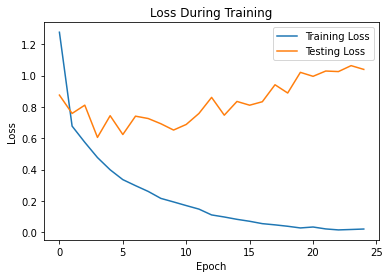

In [10]:
# === Plot the Data === #
plt.plot( history_dict['loss']     , label='Training Loss' )
plt.plot( history_dict['val_loss'] , label='Testing Loss' )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Loss' )
plt.title( 'Loss During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )

## Visualize Accuracy

This next cell shows a plot of the training and validation accuracy for the model (the exact results are saved in a future cell for later processing in another notebook.

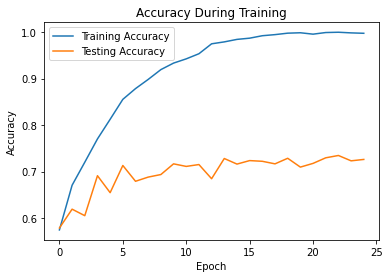

In [11]:
# === Plot the Data === #
plt.plot( history_dict['accuracy']     , label='Training Accuracy' )
plt.plot( history_dict['val_accuracy'] , label='Testing Accuracy'  )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Accuracy' )
plt.title( 'Accuracy During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )

## Save the Model 

Now that the model has been fully trained, we want to save the learned weights in order to be further evaluated later if needed. 

In [13]:
# === Save for Future Evaluation === #
hypermodel.save( 'No_Preprocess_Results/TUNED_custom_catvdog_model.h5' )

## Display Runtimes

We will show the measured preprocessing overhead time and the training time of this program in order to gain an understanding of the behavior of this baseline application. These resutls are saved in a future slide for later processing in a different notebook. 

In [14]:
for t in times:
    print( '{}: {}s'.format( t['Event'] , round( t['Time (sec)'] , 4 ) ) )

Load/Process Dataset: 19.2559s
Hyperparameter Tuning: 551.1815s
Training: 756.5375s


## Save Time Data

The above data is converted into a pandas DataFrame for saving into a formatted CSV file. This csv file will be used for processing in a different notebook. 

In [15]:
time_data  = {
    'Event': [t['Event'] for t in times],
    'Time (sec)': [t['Time (sec)'] for t in times]
}
time_table = pd.DataFrame( time_data )
time_table.to_csv( 'No_Preprocess_Results/TUNED_custom_catvdog_times.csv' , index=False )
time_table.head( )

,Event,Time (sec)
0,Load/Process Dataset,19.255929
1,Hyperparameter Tuning,551.181482
2,Training,756.537533


## Save Training/Validation Data

Finally, construct a pandas dataframe of the training loss, validation loss, training accuracy, and validation accuracy at each epoch during training. These values are saved for processing in a different notebook. 

In [16]:
model_data = {
    'Epoch': [i+1 for i in range(25)],
    'Training Accuracy': history_dict['accuracy'],
    'Validation Accuracy': history_dict['val_accuracy'],
    'Training Loss': history_dict['loss'],
    'Validation Loss': history_dict['val_loss']
}
model_table = pd.DataFrame( model_data )
model_table.to_csv( 'No_Preprocess_Results/TUNED_custom_catvdog_history.csv' , index=False )
model_table.head( len( model_table ) )

,Epoch,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,1,0.574375,0.5785,1.276775,0.875585
1,2,0.670500,0.6190,0.677716,0.758602
2,3,0.720000,0.6050,0.574364,0.811379
3,4,0.770125,0.6910,0.477050,0.605599
4,5,0.812375,0.6545,0.398913,0.744192
5,6,0.855250,0.7130,0.336086,0.624027
6,7,0.878375,0.6790,0.297636,0.741158
7,8,0.898125,0.6880,0.260850,0.726190
8,9,0.919250,0.6935,0.216304,0.692801
9,10,0.933250,0.7165,0.193716,0.652531
